# K-Means Clustering for a Netflix Movie Recommendation System

In [8]:
import jupyterthemes as jt
!jt -t onedork

- Importing libraries

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msgno

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

import unicodedata

In [10]:
import warnings
warnings.filterwarnings('ignore')


import re, string, unicodedata
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import TweetTokenizer

from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JANUARIUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


- Loading the dataset

In [11]:
Netflix=pd.read_csv("Data.csv")
Netflix

show_id     type                                    title  \
0         s1  TV Show                                       3%   
1         s2    Movie                                     7:19   
2         s3    Movie                                    23:59   
3         s4    Movie                                        9   
4         s5    Movie                                       21   
...      ...      ...                                      ...   
7782   s7783    Movie                                     Zozo   
7783   s7784    Movie                                   Zubaan   
7784   s7785    Movie                        Zulu Man in Japan   
7785   s7786  TV Show                    Zumbo's Just Desserts   
7786   s7787    Movie  ZZ TOP: THAT LITTLE OL' BAND FROM TEXAS   

               director                                               cast  \
0                   NaN  João Miguel, Bianca Comparato, Michel Gomes, R...   
1     Jorge Michel Grau  Demián Bichir, Héctor Bonilla, Oscar Serrano, ...   
2          Gilbert Chan  Tedd Chan, Stella Chung, Henley Hii, Lawrence ...   
3           Shane Acker  Elijah Wood, John C. Reilly, Jennifer Connelly...   
4        Robert Luketic  Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...   
...                 ...                                                ...   
7782        Josef Fares  Imad Creidi, Antoinette Turk, Elias Gergi, Car...   
7783        Mozez Singh  Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...   
7784                NaN                                            Nasty C   
7785                NaN                         Adriano Zumbo, Rachel Khoo   
7786           Sam Dunn                                                NaN   

                                                country          date_added  \
0                                                Brazil     August 14, 2020   
1                                                Mexico   December 23, 2016   
2                                             Singapore   December 20, 2018   
3                                         United States   November 16, 2017   
4                                         United States     January 1, 2020   
...                                                 ...                 ...   
7782  Sweden, Czech Republic, United Kingdom, Denmar...    October 19, 2020   
7783                                              India       March 2, 2019   
7784                                                NaN  September 25, 2020   
7785                                          Australia    October 31, 2020   
7786              United Kingdom, Canada, United States       March 1, 2020   

      release_year rating   duration  \
0             2020  TV-MA  4 Seasons   
1             2016  TV-MA     93 min   
2             2011      R     78 min   
3             2009  PG-13     80 min   
4             2008  PG-13    123 min   
...            ...    ...        ...   
7782          2005  TV-MA     99 min   
7783          2015  TV-14    111 min   
7784          2019  TV-MA     44 min   
7785          2019  TV-PG   1 Season   
7786          2019  TV-MA     90 min   

                                              listed_in  \
0     International TV Shows, TV Dramas, TV Sci-Fi &...   
1                          Dramas, International Movies   
2                   Horror Movies, International Movies   
3     Action & Adventure, Independent Movies, Sci-Fi...   
4                                                Dramas   
...                                                 ...   
7782                       Dramas, International Movies   
7783     Dramas, International Movies, Music & Musicals   
7784  Documentaries, International Movies, Music & M...   
7785                 International TV Shows, Reality TV   
7786                    Documentaries, Music & Musicals   

                                            description  
0     In a future where the elite inhabit an island ...  
1     After a devast

- Checking the data types

In [12]:
Netflix.dtypes

show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object

### Data Cleaning & Preparation

- Converting release year and date added into a date dtype

In [13]:
Netflix['release_year'] = pd.to_datetime(Netflix['release_year'])
Netflix['date_added'] = pd.to_datetime(Netflix['date_added'], format='mixed')

Netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       7787 non-null   object        
 1   type          7787 non-null   object        
 2   title         7787 non-null   object        
 3   director      5398 non-null   object        
 4   cast          7069 non-null   object        
 5   country       7280 non-null   object        
 6   date_added    7777 non-null   datetime64[ns]
 7   release_year  7787 non-null   datetime64[ns]
 8   rating        7780 non-null   object        
 9   duration      7787 non-null   object        
 10  listed_in     7787 non-null   object        
 11  description   7787 non-null   object        
dtypes: datetime64[ns](2), object(10)
memory usage: 730.2+ KB


- To check for duplicates

In [14]:
Netflix.duplicated().value_counts()

False    7787
Name: count, dtype: int64

- To get a visual understanding of the missingness : We use a matrix to understand the position of missingness

<Axes: >

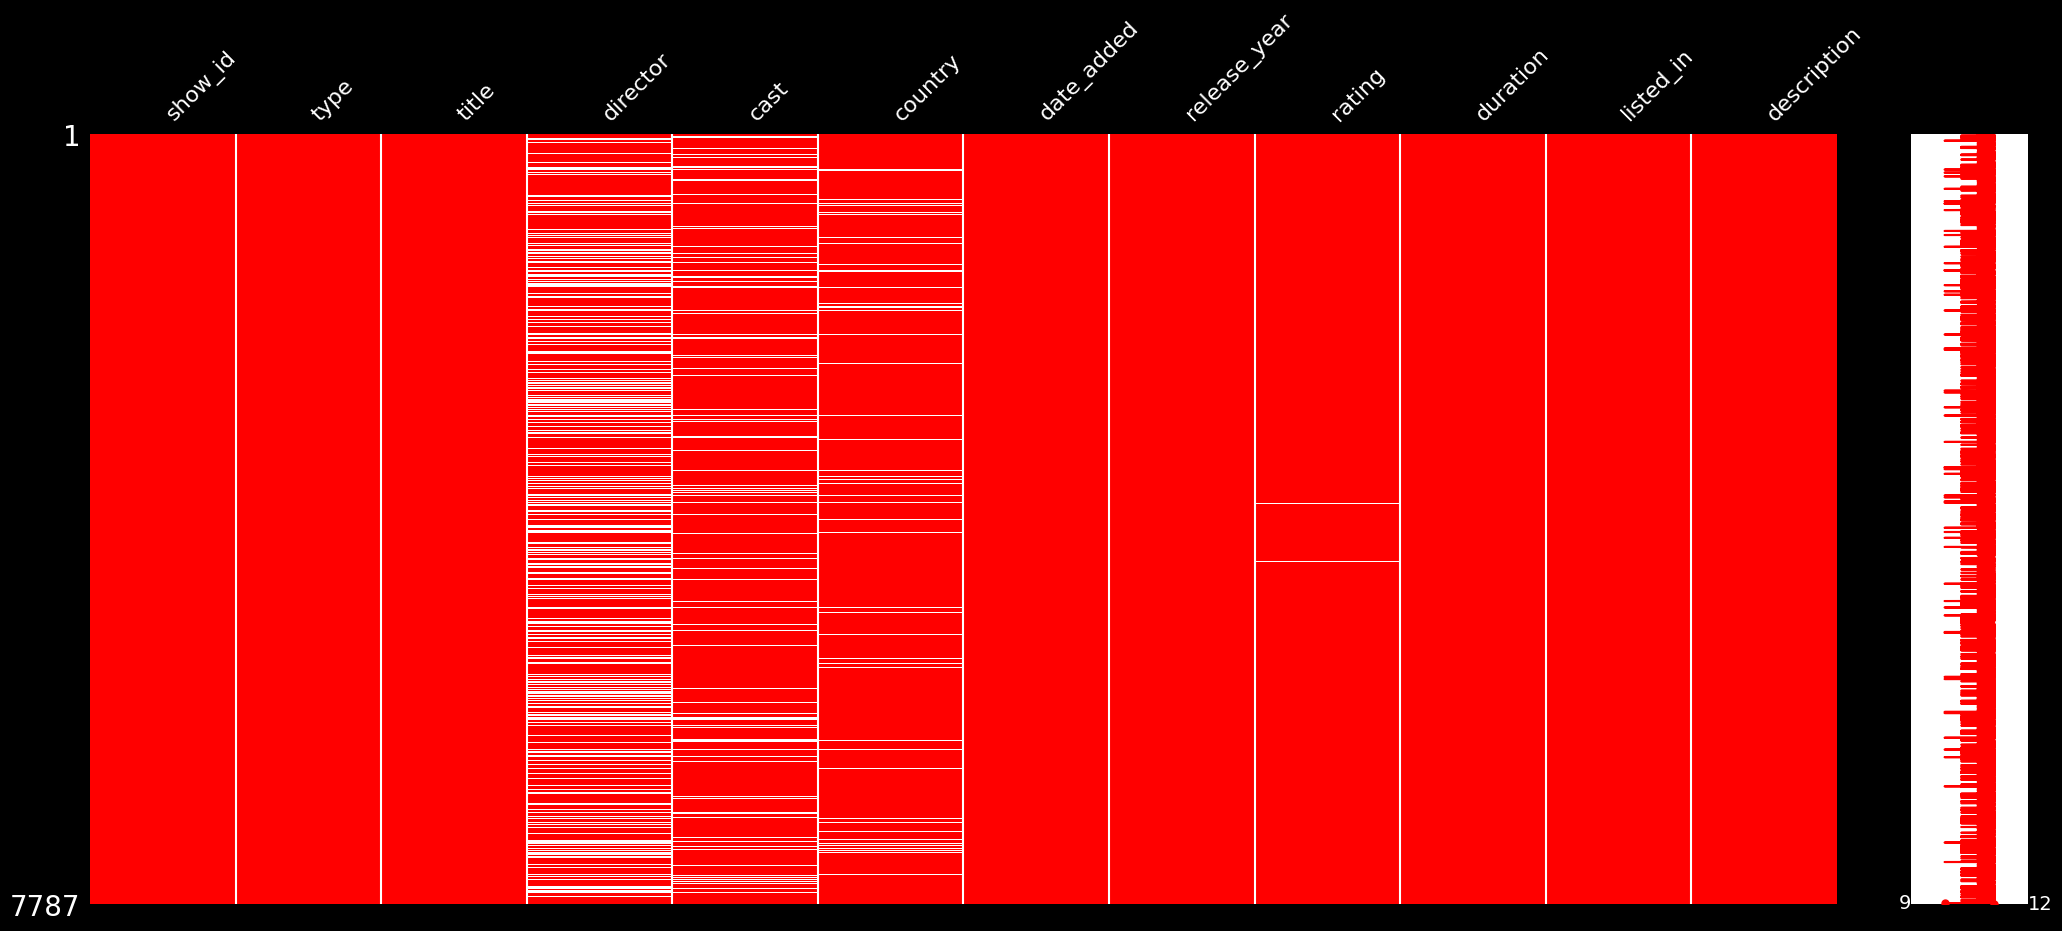

In [15]:
plt.style.use('dark_background')

plt.rcParams['font.size'] = 20
msgno.matrix(Netflix, color=(1.0, 0.0, 0.0))

- Solutions to the missing bits:
   - Director, cast & country columns can be filled with 'unknown'.
   - The rating column can be filled with the modal rating
   - Missing date added rows will be dropped

<Axes: >

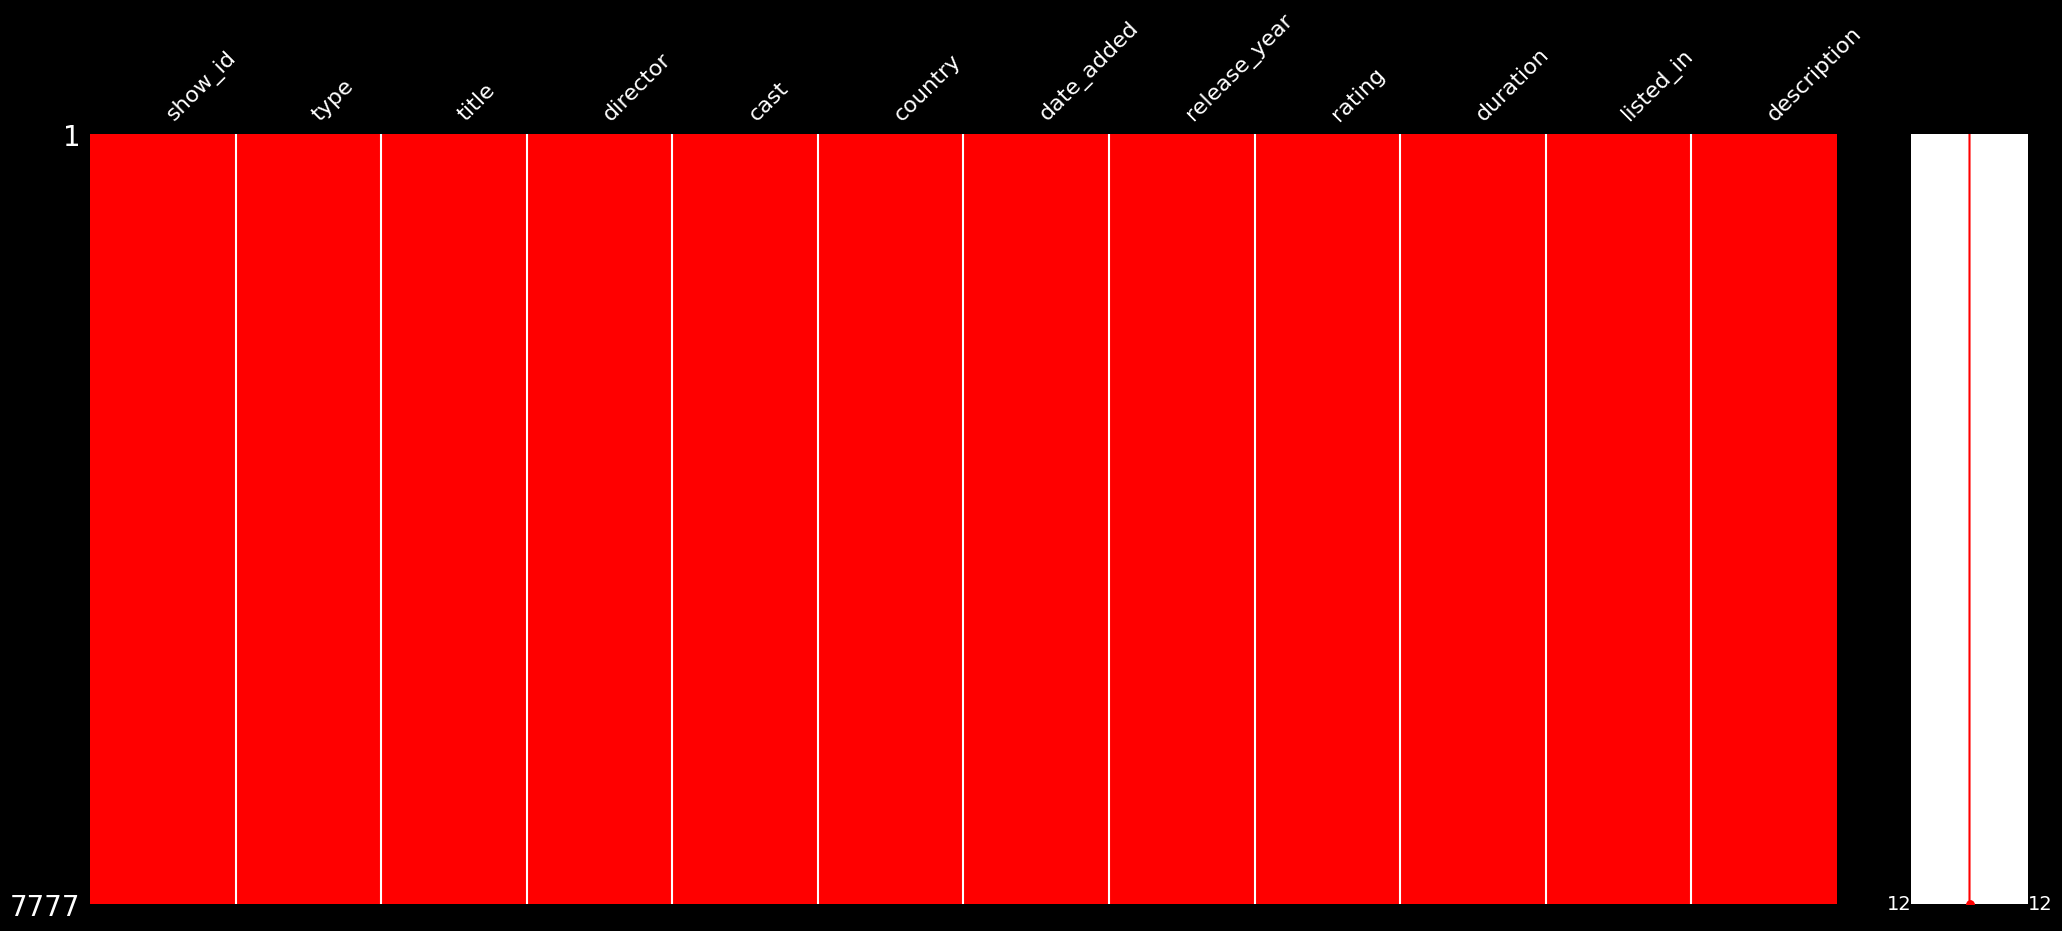

In [16]:
plt.style.use('dark_background')
plt.rcParams['font.size'] = 20
Netflix[['director','cast','country']] = Netflix[['director','cast','country']].fillna('Unknown')
Netflix['rating'] = Netflix['rating'].fillna(Netflix['rating'].mode()[0])
Netflix.dropna(axis=0, inplace = True)

plt.rcParams['font.size'] = 20
msgno.matrix(Netflix, color=(1.0, 0.0, 0.0))

- Categorizing the various ratings

In [17]:
rating_map = {'TV-MA':'Adults',
              'R':'Adults',
              'PG-13':'Teens',
              'TV-14':'Young Adults',
              'TV-PG':'Older Kids',
              'NR':'Adults',
              'TV-G':'Kids',
              'TV-Y':'Kids',
              'TV-Y7':'Older Kids',
              'PG':'Older Kids',
              'G':'Kids',
              'NC-17':'Adults',
              'TV-Y7-FV':'Older Kids',
              'UR':'Adults'}

Netflix['rating'].replace(rating_map, inplace = True)
Netflix['rating'].unique()

array(['Adults', 'Teens', 'Young Adults', 'Older Kids', 'Kids'],
      dtype=object)

### EDA

- #### Ratings 

Text(0.5, 1.0, 'Number of shows on Netflix for different age groups')

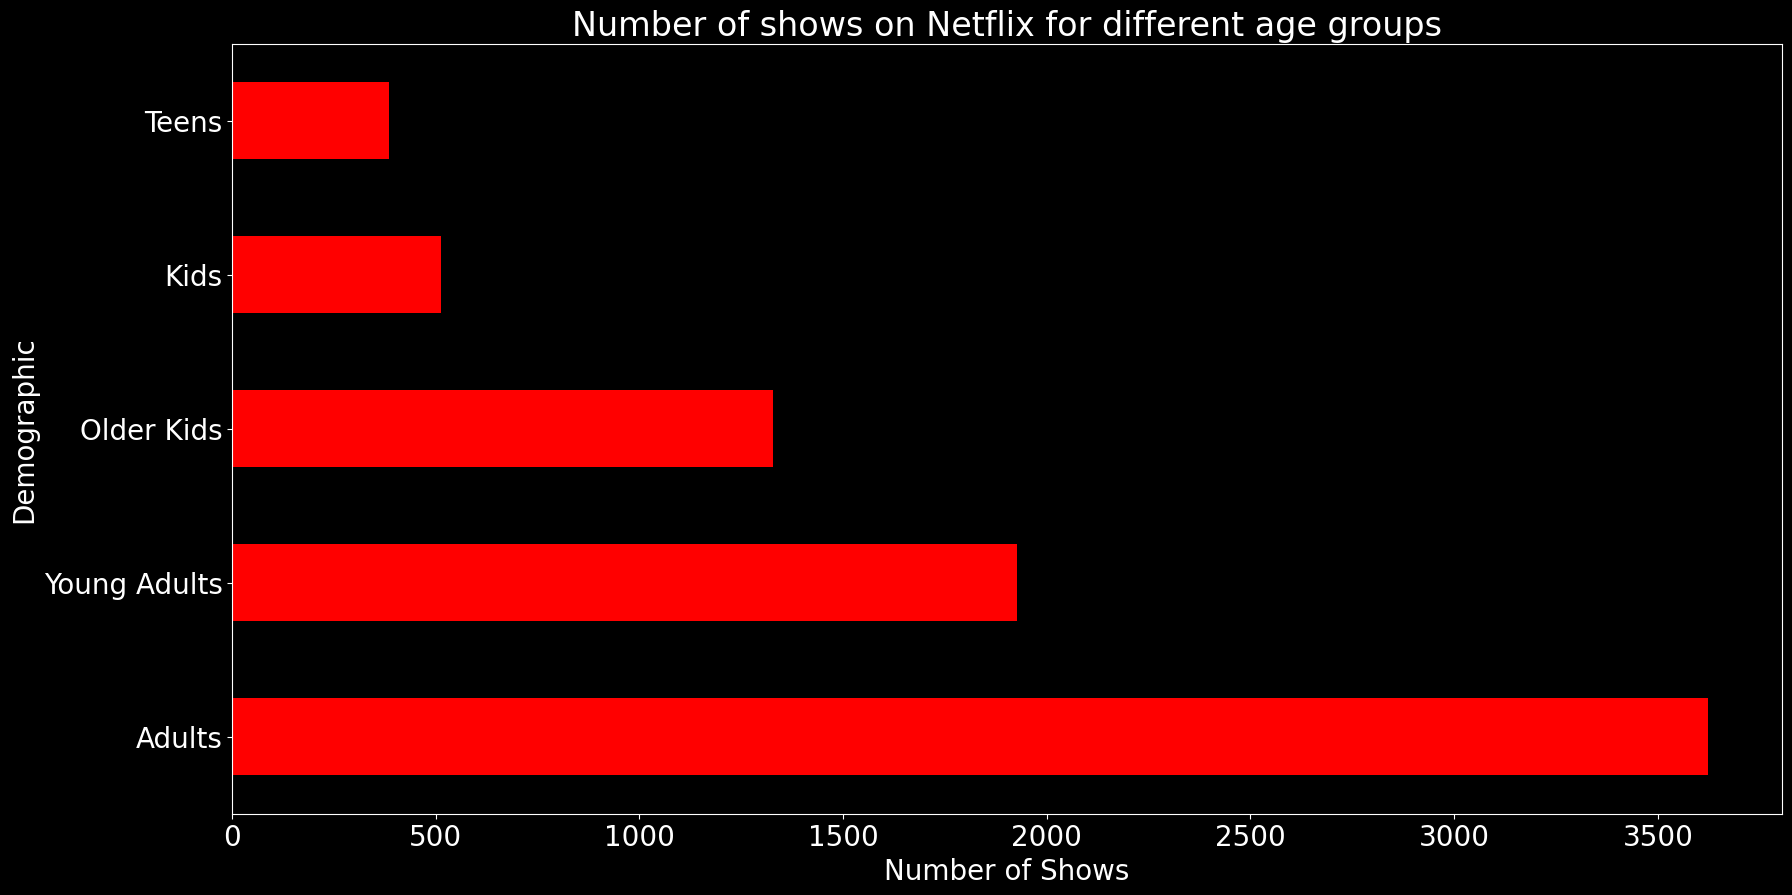

In [18]:
plt.figure(figsize=(20,10))
plt.rcParams['font.size'] = 20
Netflix.rating.value_counts(ascending=False).plot(kind='barh', color='red')
plt.ylabel('Demographic')
plt.xlabel('Number of Shows')
plt.title('Number of shows on Netflix for different age groups')

- Insight:
   - Adults are the most catered for demographic by Netflix followed by young adults all the way to teenagers. 
    

- #### Comparison of Movies and TV Shows in the dataset

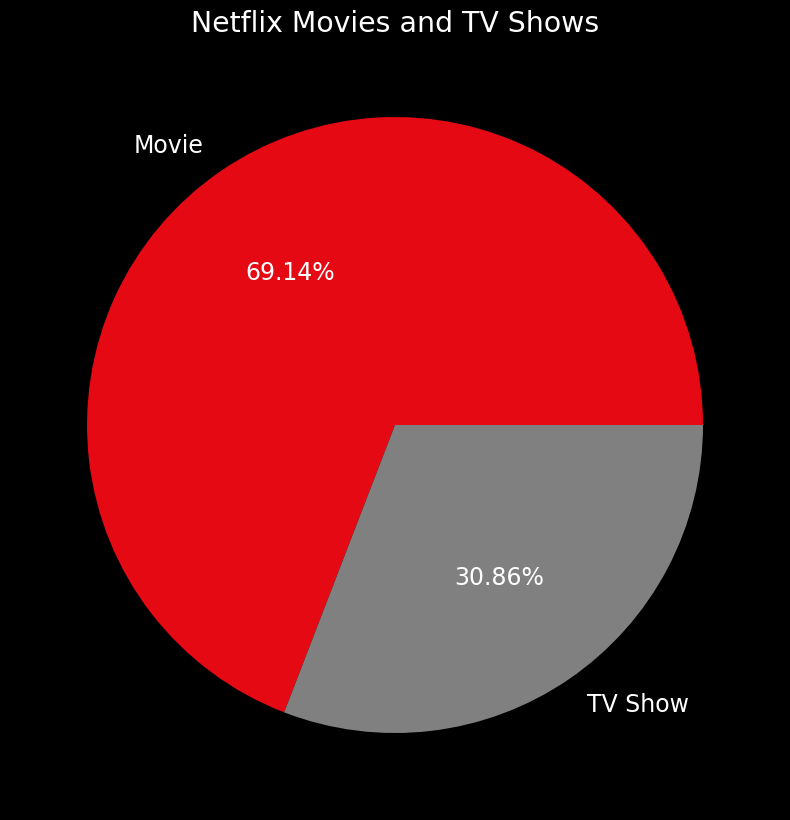

In [19]:
colors = ['#e50914', '#808080']

plt.figure(figsize=(20, 10))
plt.rcParams['font.size'] = 17
plt.style.use('dark_background')
Netflix.type.value_counts().plot(kind='pie', autopct='%1.2f%%',  colors=colors)
plt.ylabel('')
plt.title('Netflix Movies and TV Shows')

plt.show()

- 69.14% of the films in the dataset are movies while 30.86% are TV shows

- #### Directors

Text(0.5, 1.0, 'Top 12 directors by number of shows directed')

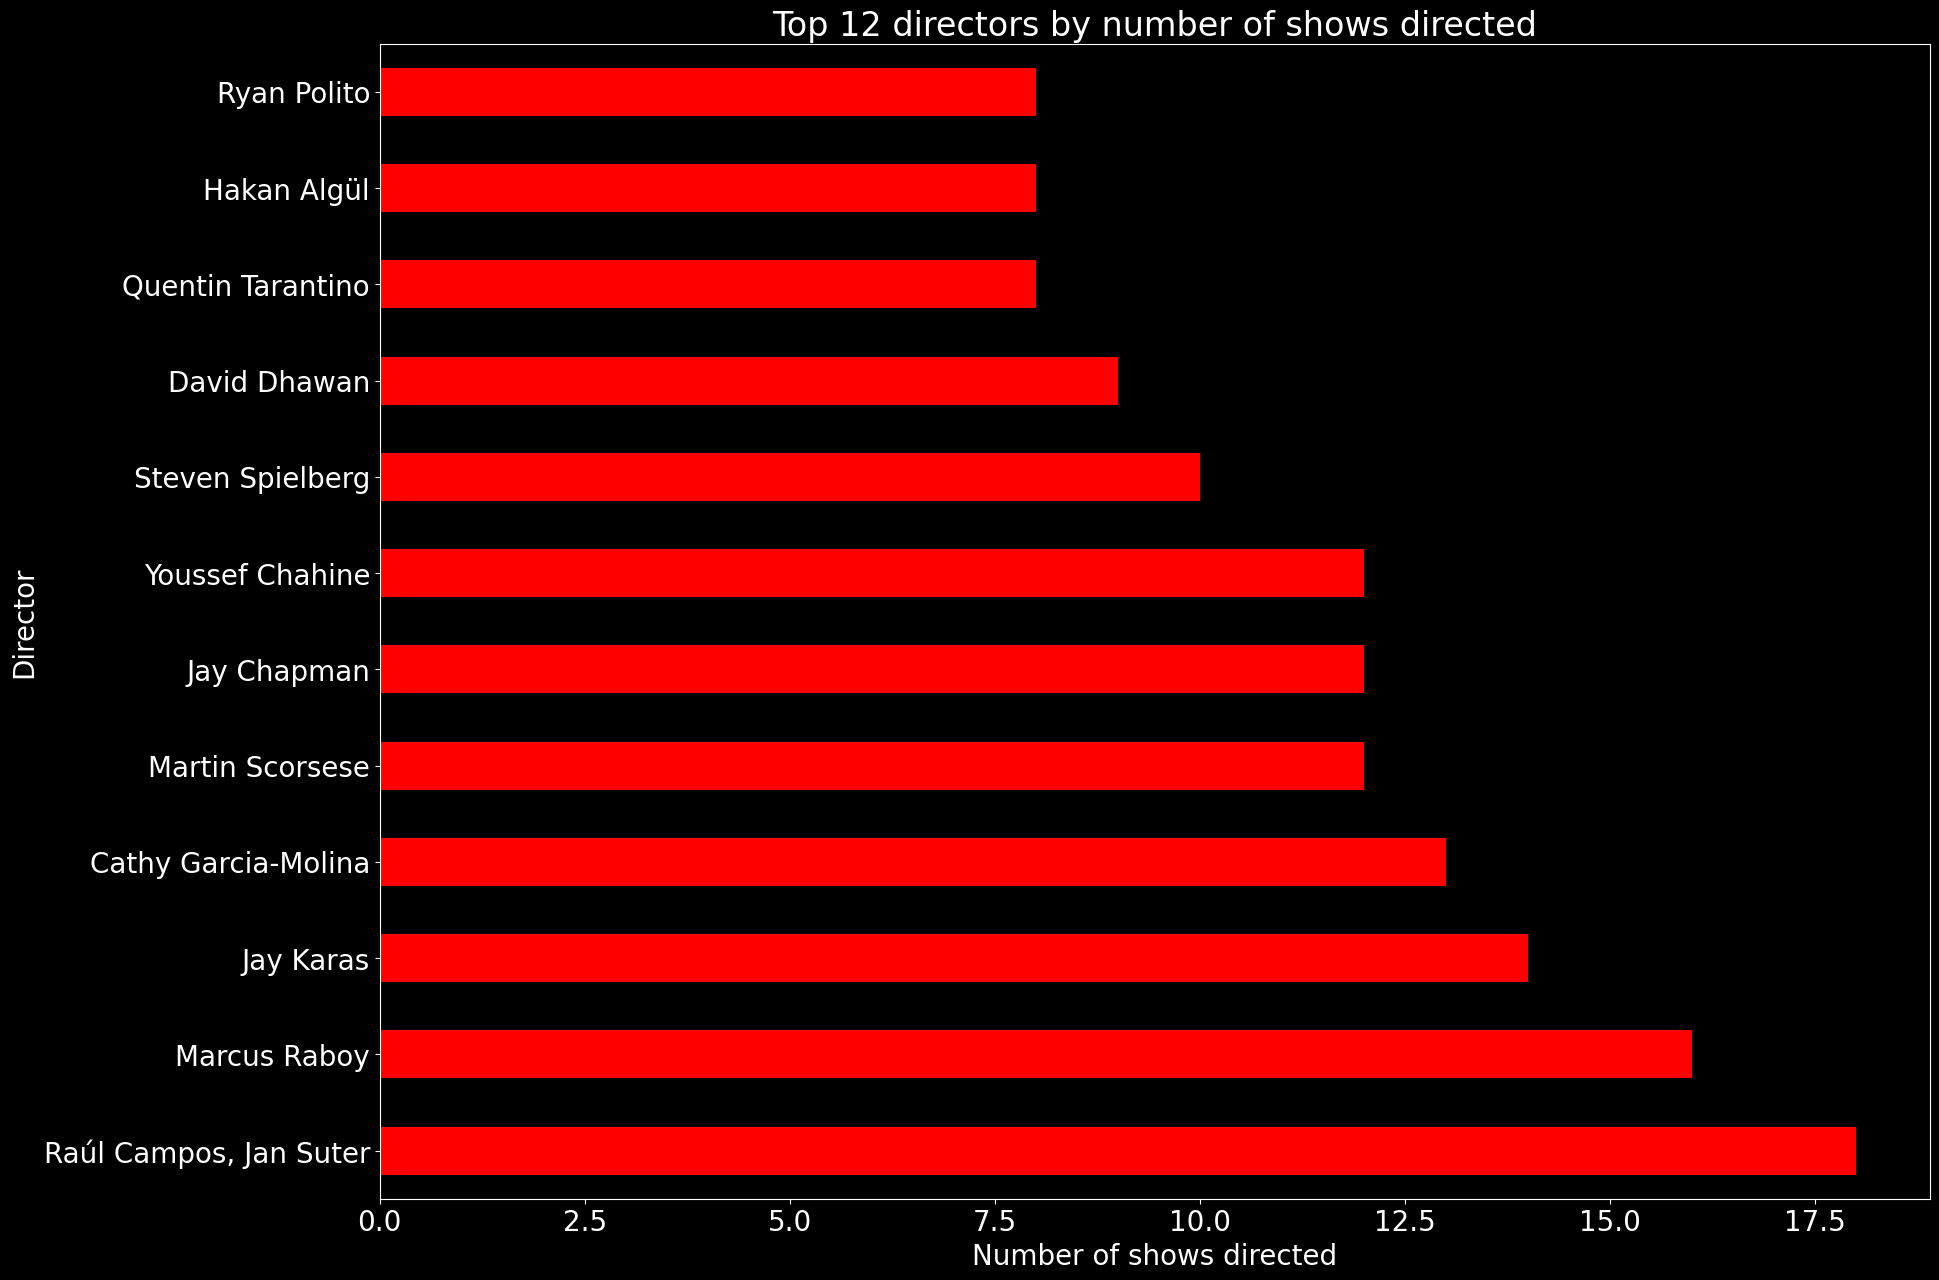

In [20]:
plt.figure(figsize=(20,15))
plt.rcParams['font.size'] = 20
Netflix[~(Netflix['director']=='Unknown')].director.value_counts(ascending=True).nlargest(12).plot(kind='barh', color='red')
plt.ylabel('Director')
plt.xlabel('Number of shows directed')
plt.title('Top 12 directors by number of shows directed')

- Raul Campos and Jan Suter have directed the highest number of films(18)

- #### Cast

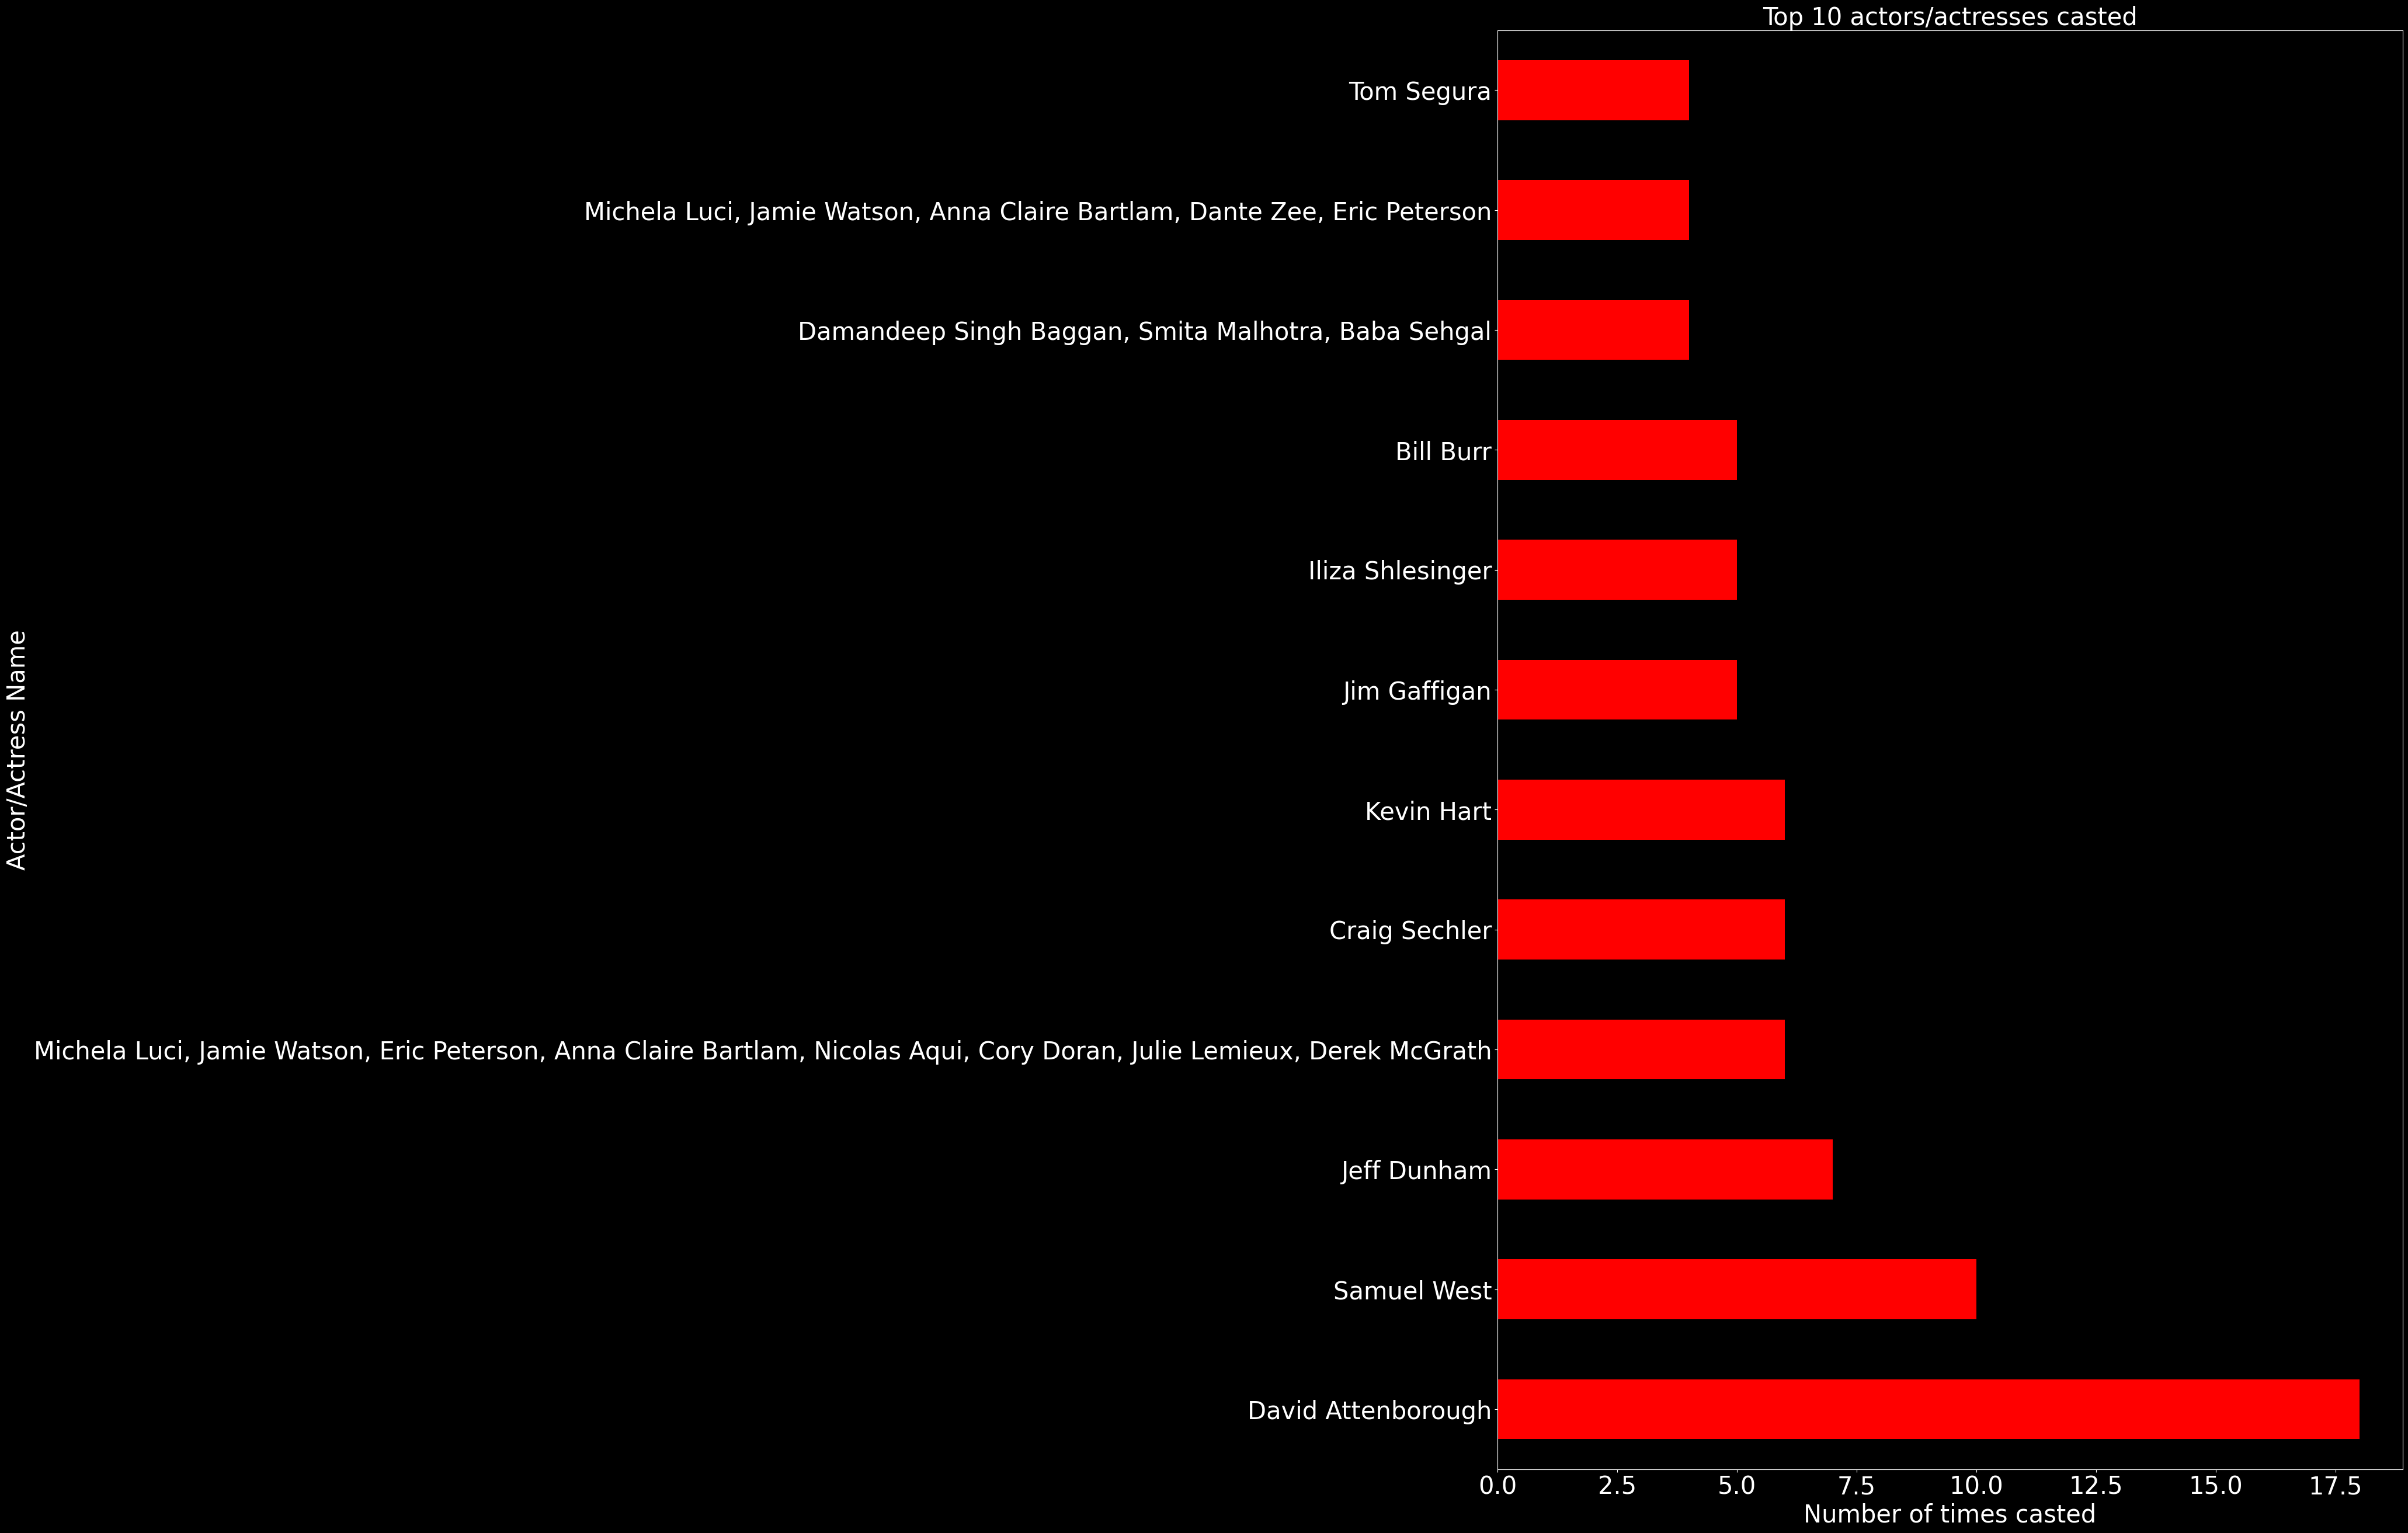

In [21]:
plt.figure(figsize=(20,32))
plt.rcParams['font.size'] = 30
Netflix[~(Netflix['cast']=='Unknown')].cast.value_counts(ascending=True).nlargest(12).plot(kind='barh', color='red')
plt.ylabel('Actor/Actress Name').set_fontsize(30)
plt.xlabel('Number of times casted').set_fontsize(30)
plt.title('Top 10 actors/actresses casted').set_fontsize(30)

- David Attenborough was the most casted (18) actor followed by Samuel West. 

- #### Countries

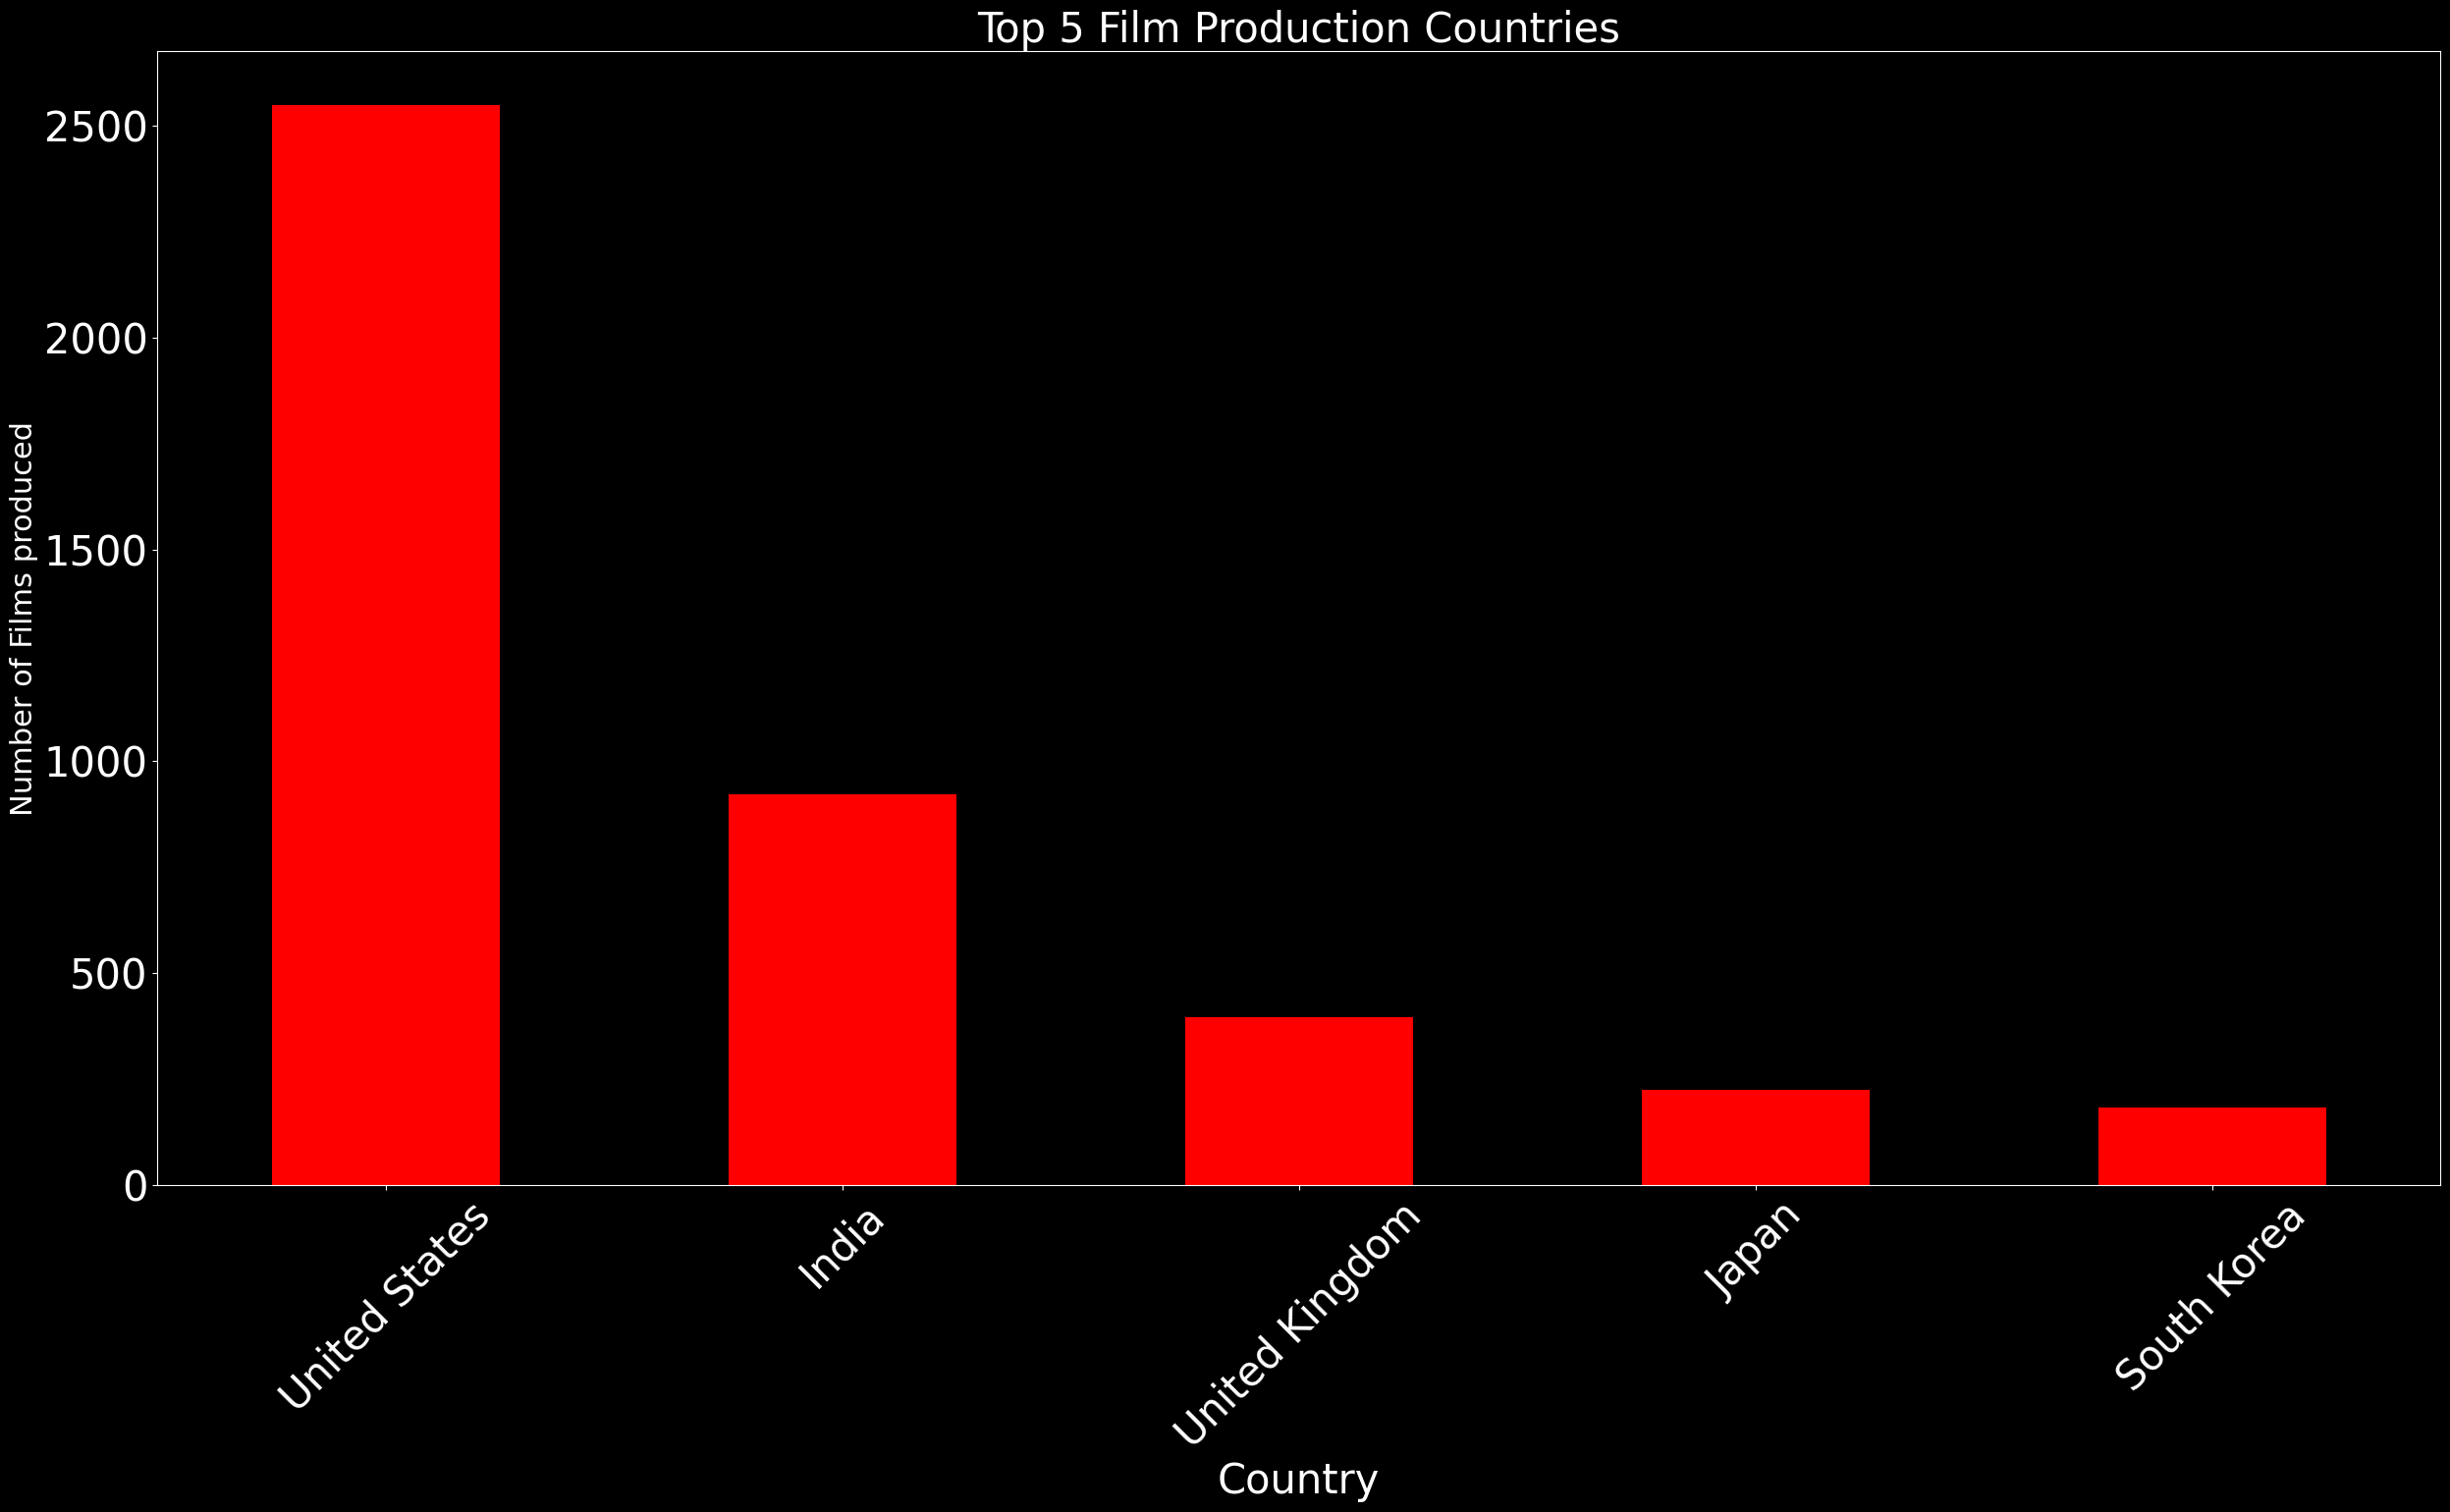

In [22]:
plt.figure(figsize=(30,15))
Netflix[~(Netflix['country']=='Unknown')].country.value_counts(ascending=True).nlargest(5).plot(kind='bar', color='red')
plt.ylabel('Number of Films produced').set_fontsize(22)
plt.xlabel('Country').set_fontsize(30)
plt.xticks(rotation = 45)
plt.title('Top 5 Film Production Countries').set_fontsize(30)

In [23]:
Netflix.country.value_counts().nlargest(1).sum()/len(Netflix)*100

32.77613475633277

In [24]:
Netflix.country.value_counts().nlargest(5).sum()/len(Netflix)*100

59.135913591359135

- United States accounts for ~33% of the films in the dataset.
  - The top 5 countries account for ~ 59% of the films in the dataset

- #### Film releases per year

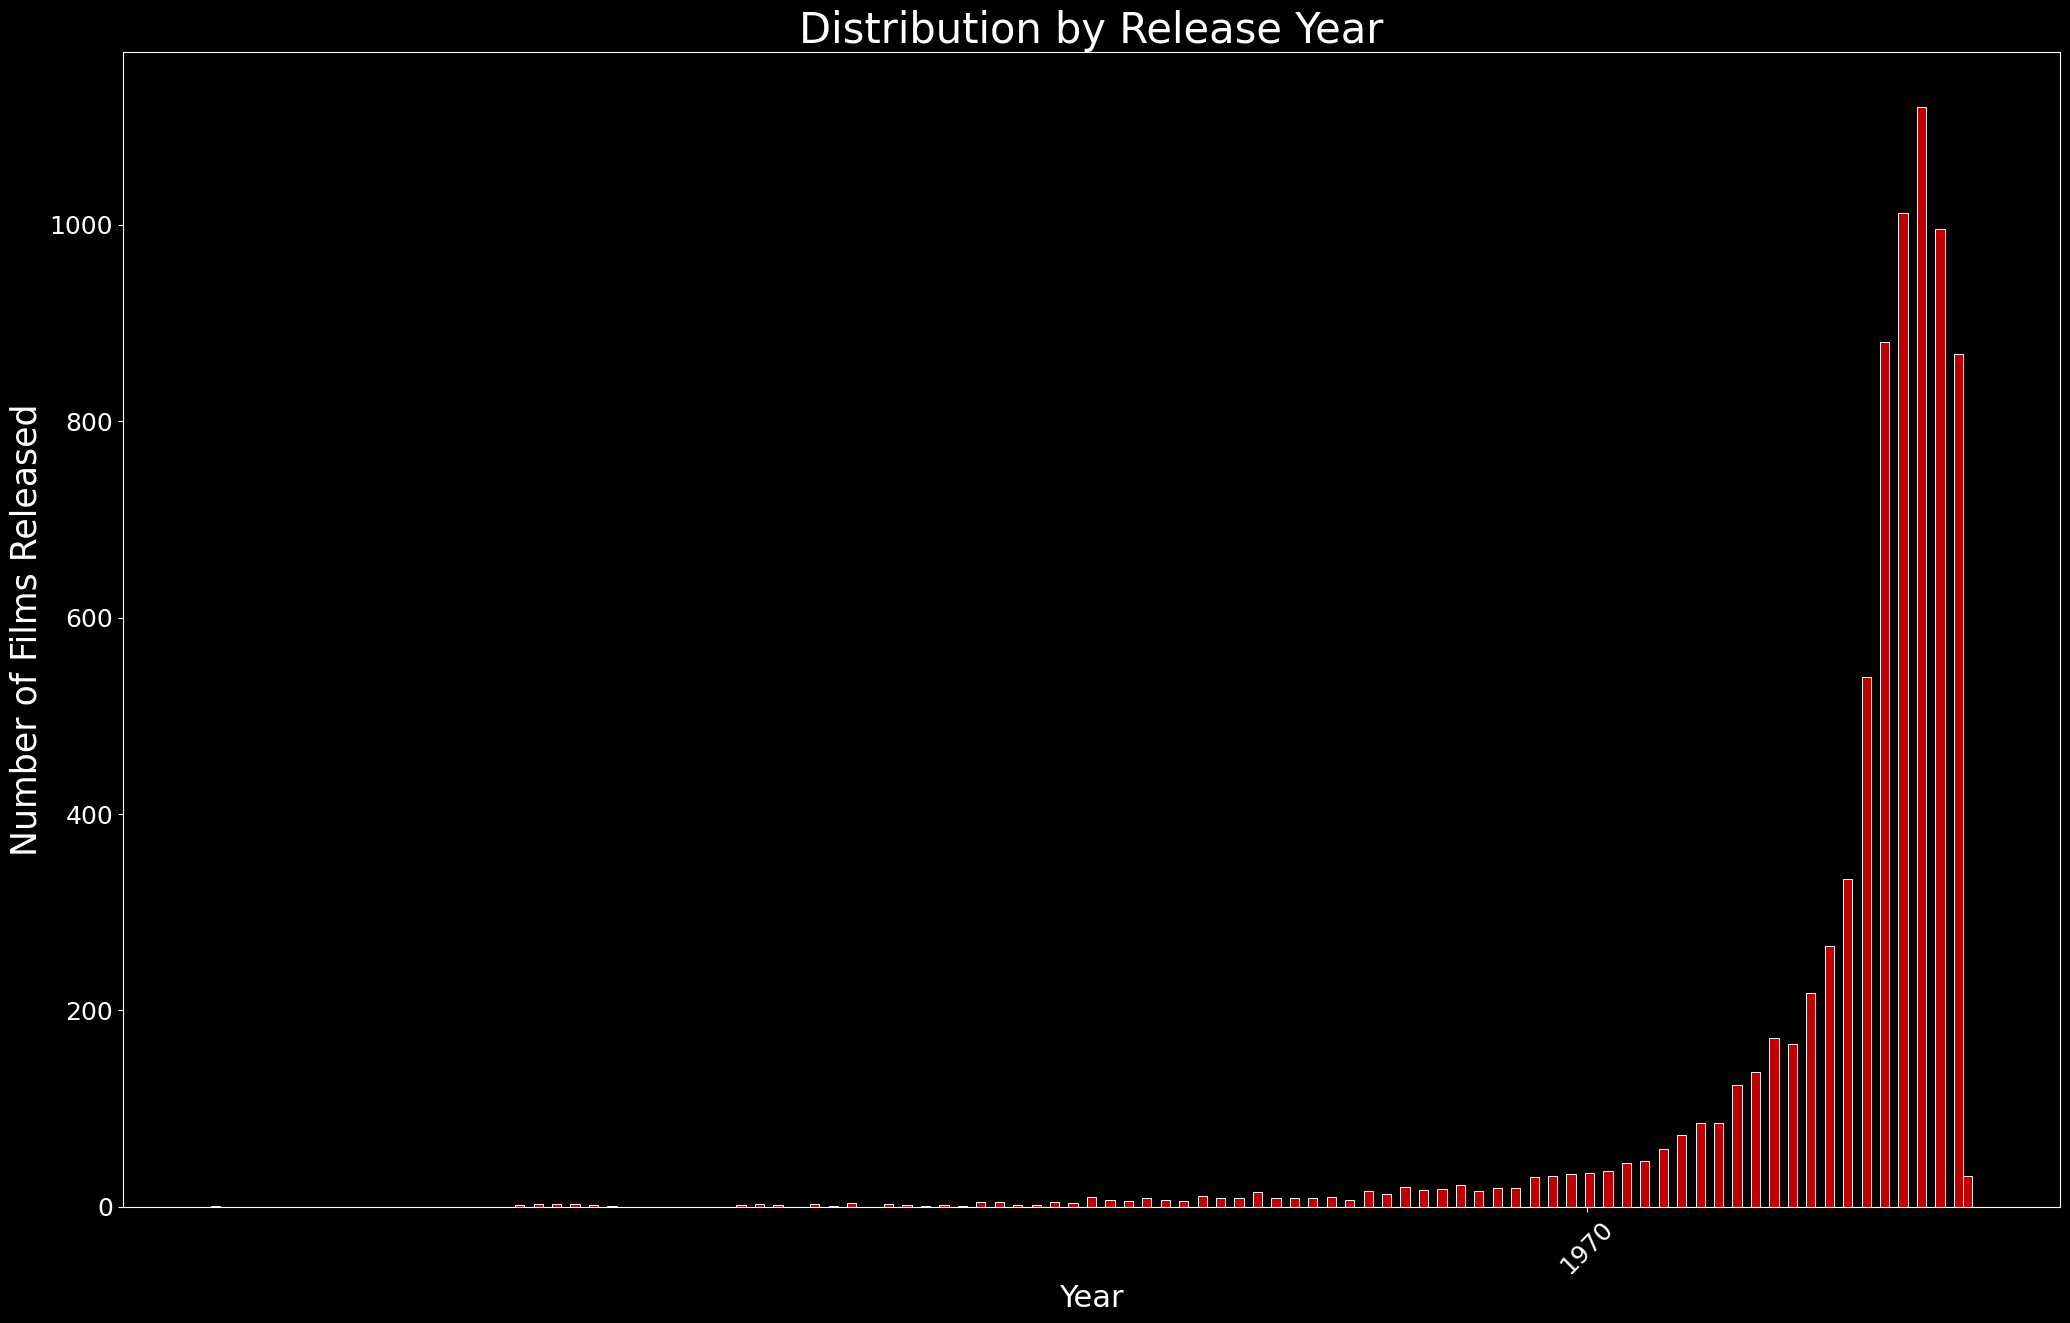

In [25]:
plt.figure(figsize=(25,15))
plt.rcParams['font.size'] = 18
sns.histplot(Netflix['release_year'], color='red')
plt.ylabel('Number of Films Released').set_fontsize(25)
plt.xlabel('Year').set_fontsize(22)
plt.xticks(rotation = 45)
plt.title('Distribution by Release Year').set_fontsize(30)

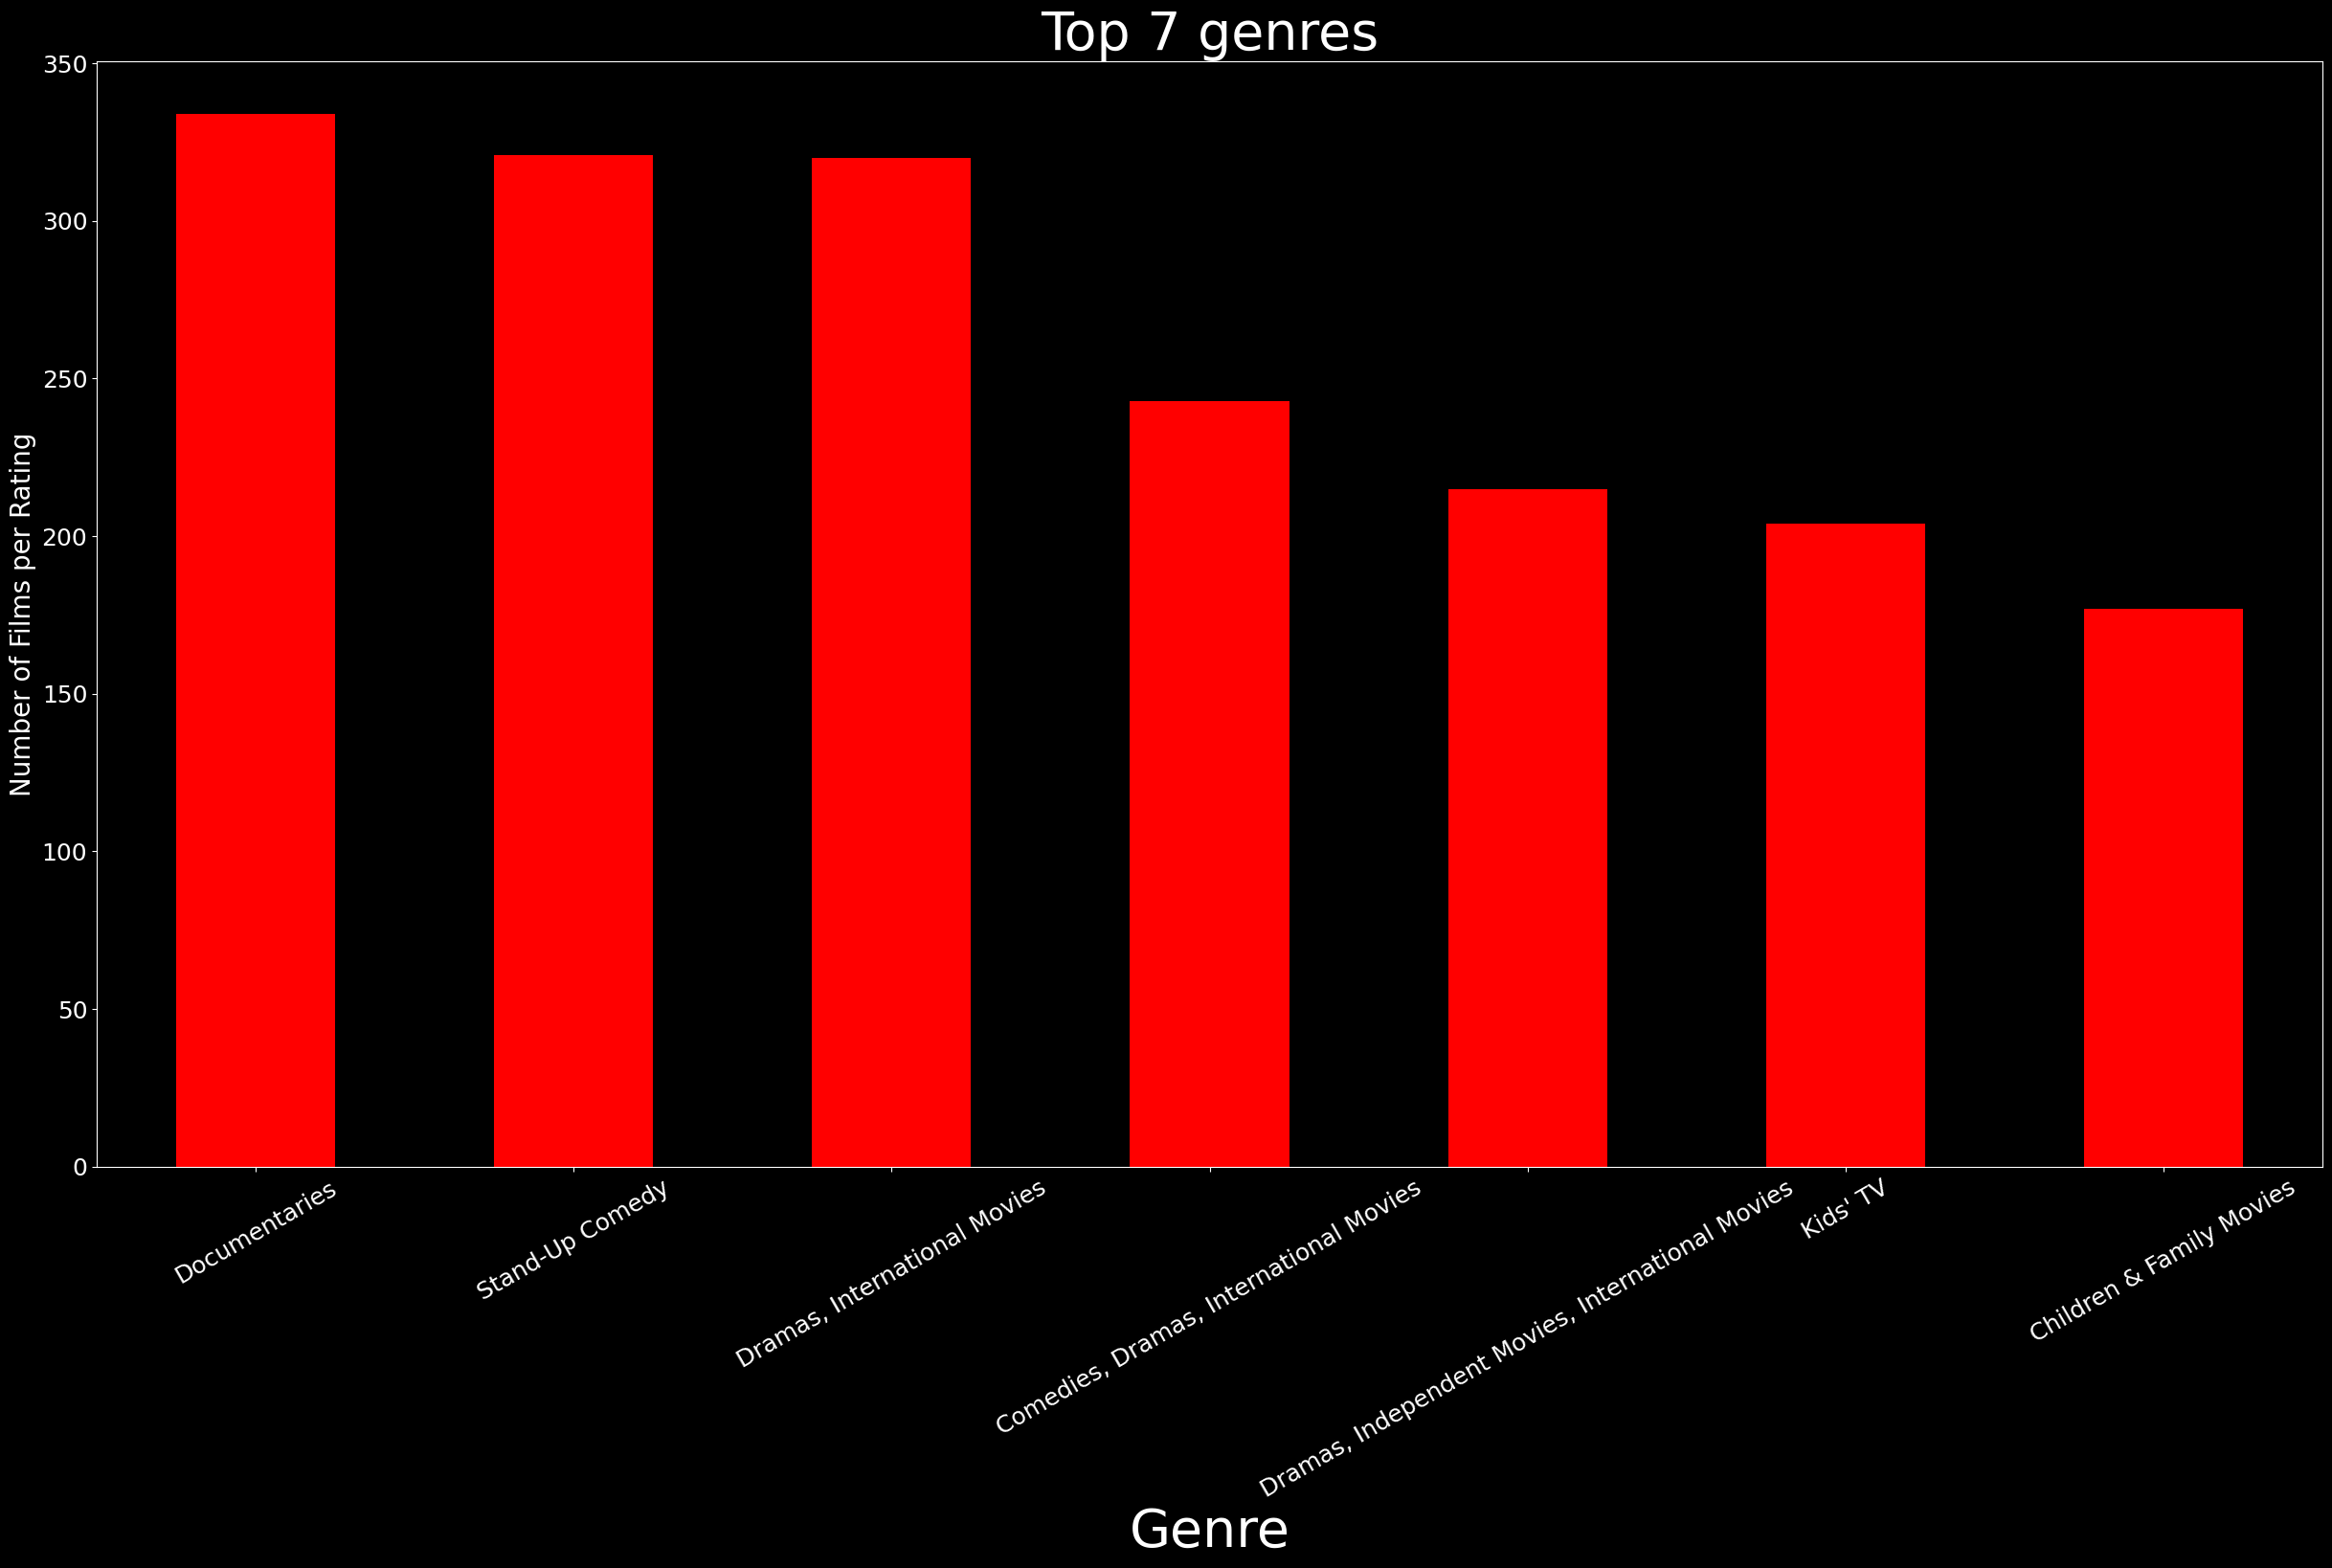

In [26]:
plt.figure(figsize=(30,15))
plt.rcParams['font.size'] = 18

Netflix.listed_in.value_counts().nlargest(7).plot(kind='bar', color='red')
plt.ylabel('Number of Films per Rating').set_fontsize(20)
plt.xlabel('Genre').set_fontsize(40)
plt.xticks(rotation = 30)
plt.title('Top 7 genres').set_fontsize(40)

In [27]:
Netflix.listed_in.value_counts().nlargest(1).sum()/len(Netflix)*100

4.294715185804295

- ~ 4% of the films were listed as documentaries

In [28]:
Netflix.listed_in.value_counts().nlargest(2).sum()/len(Netflix)*100

8.422270798508421

- ~ 8% of the films were listed as either documentaries or stand-up-comedy

In [29]:
Netflix.listed_in.value_counts().nlargest(10).sum()/len(Netflix)*100

29.78012086922978

- The top 10 genres accounted for ~30% of the Movies and TV Shows in the dataset

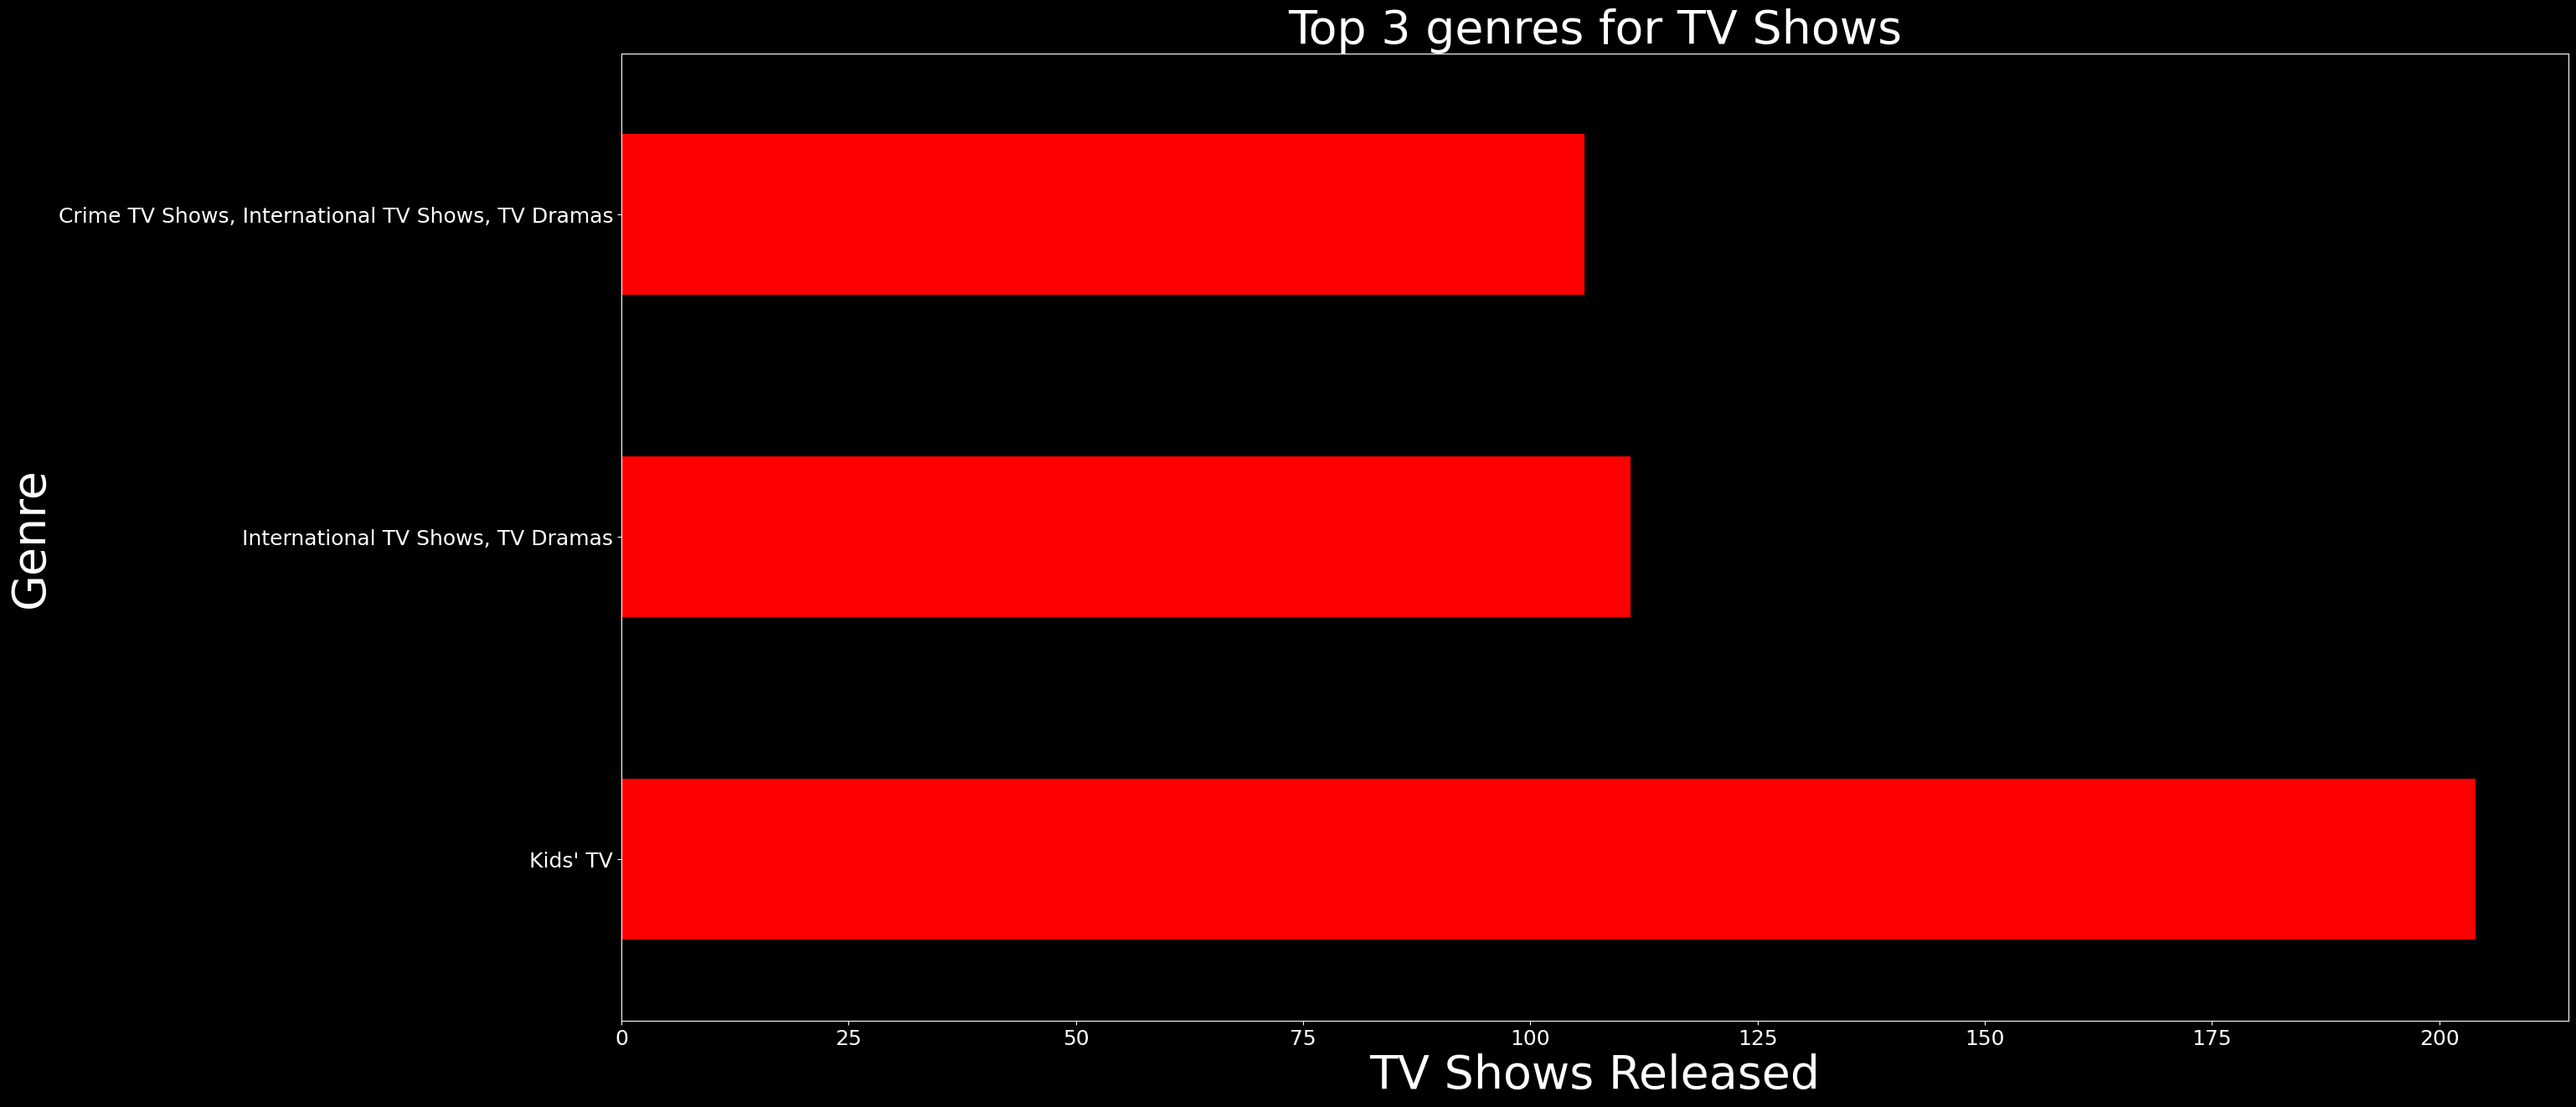

In [30]:
plt.figure(figsize=(30,15))
Netflix[Netflix['type']=='TV Show'].listed_in.value_counts().nlargest(3).plot(kind='barh', color='red')
plt.ylabel('Genre').set_fontsize(40)
plt.xlabel('TV Shows Released').set_fontsize(40)
plt.title('Top 3 genres for TV Shows').set_fontsize(40)

- Kid's TV shows are the most popular TV shows.

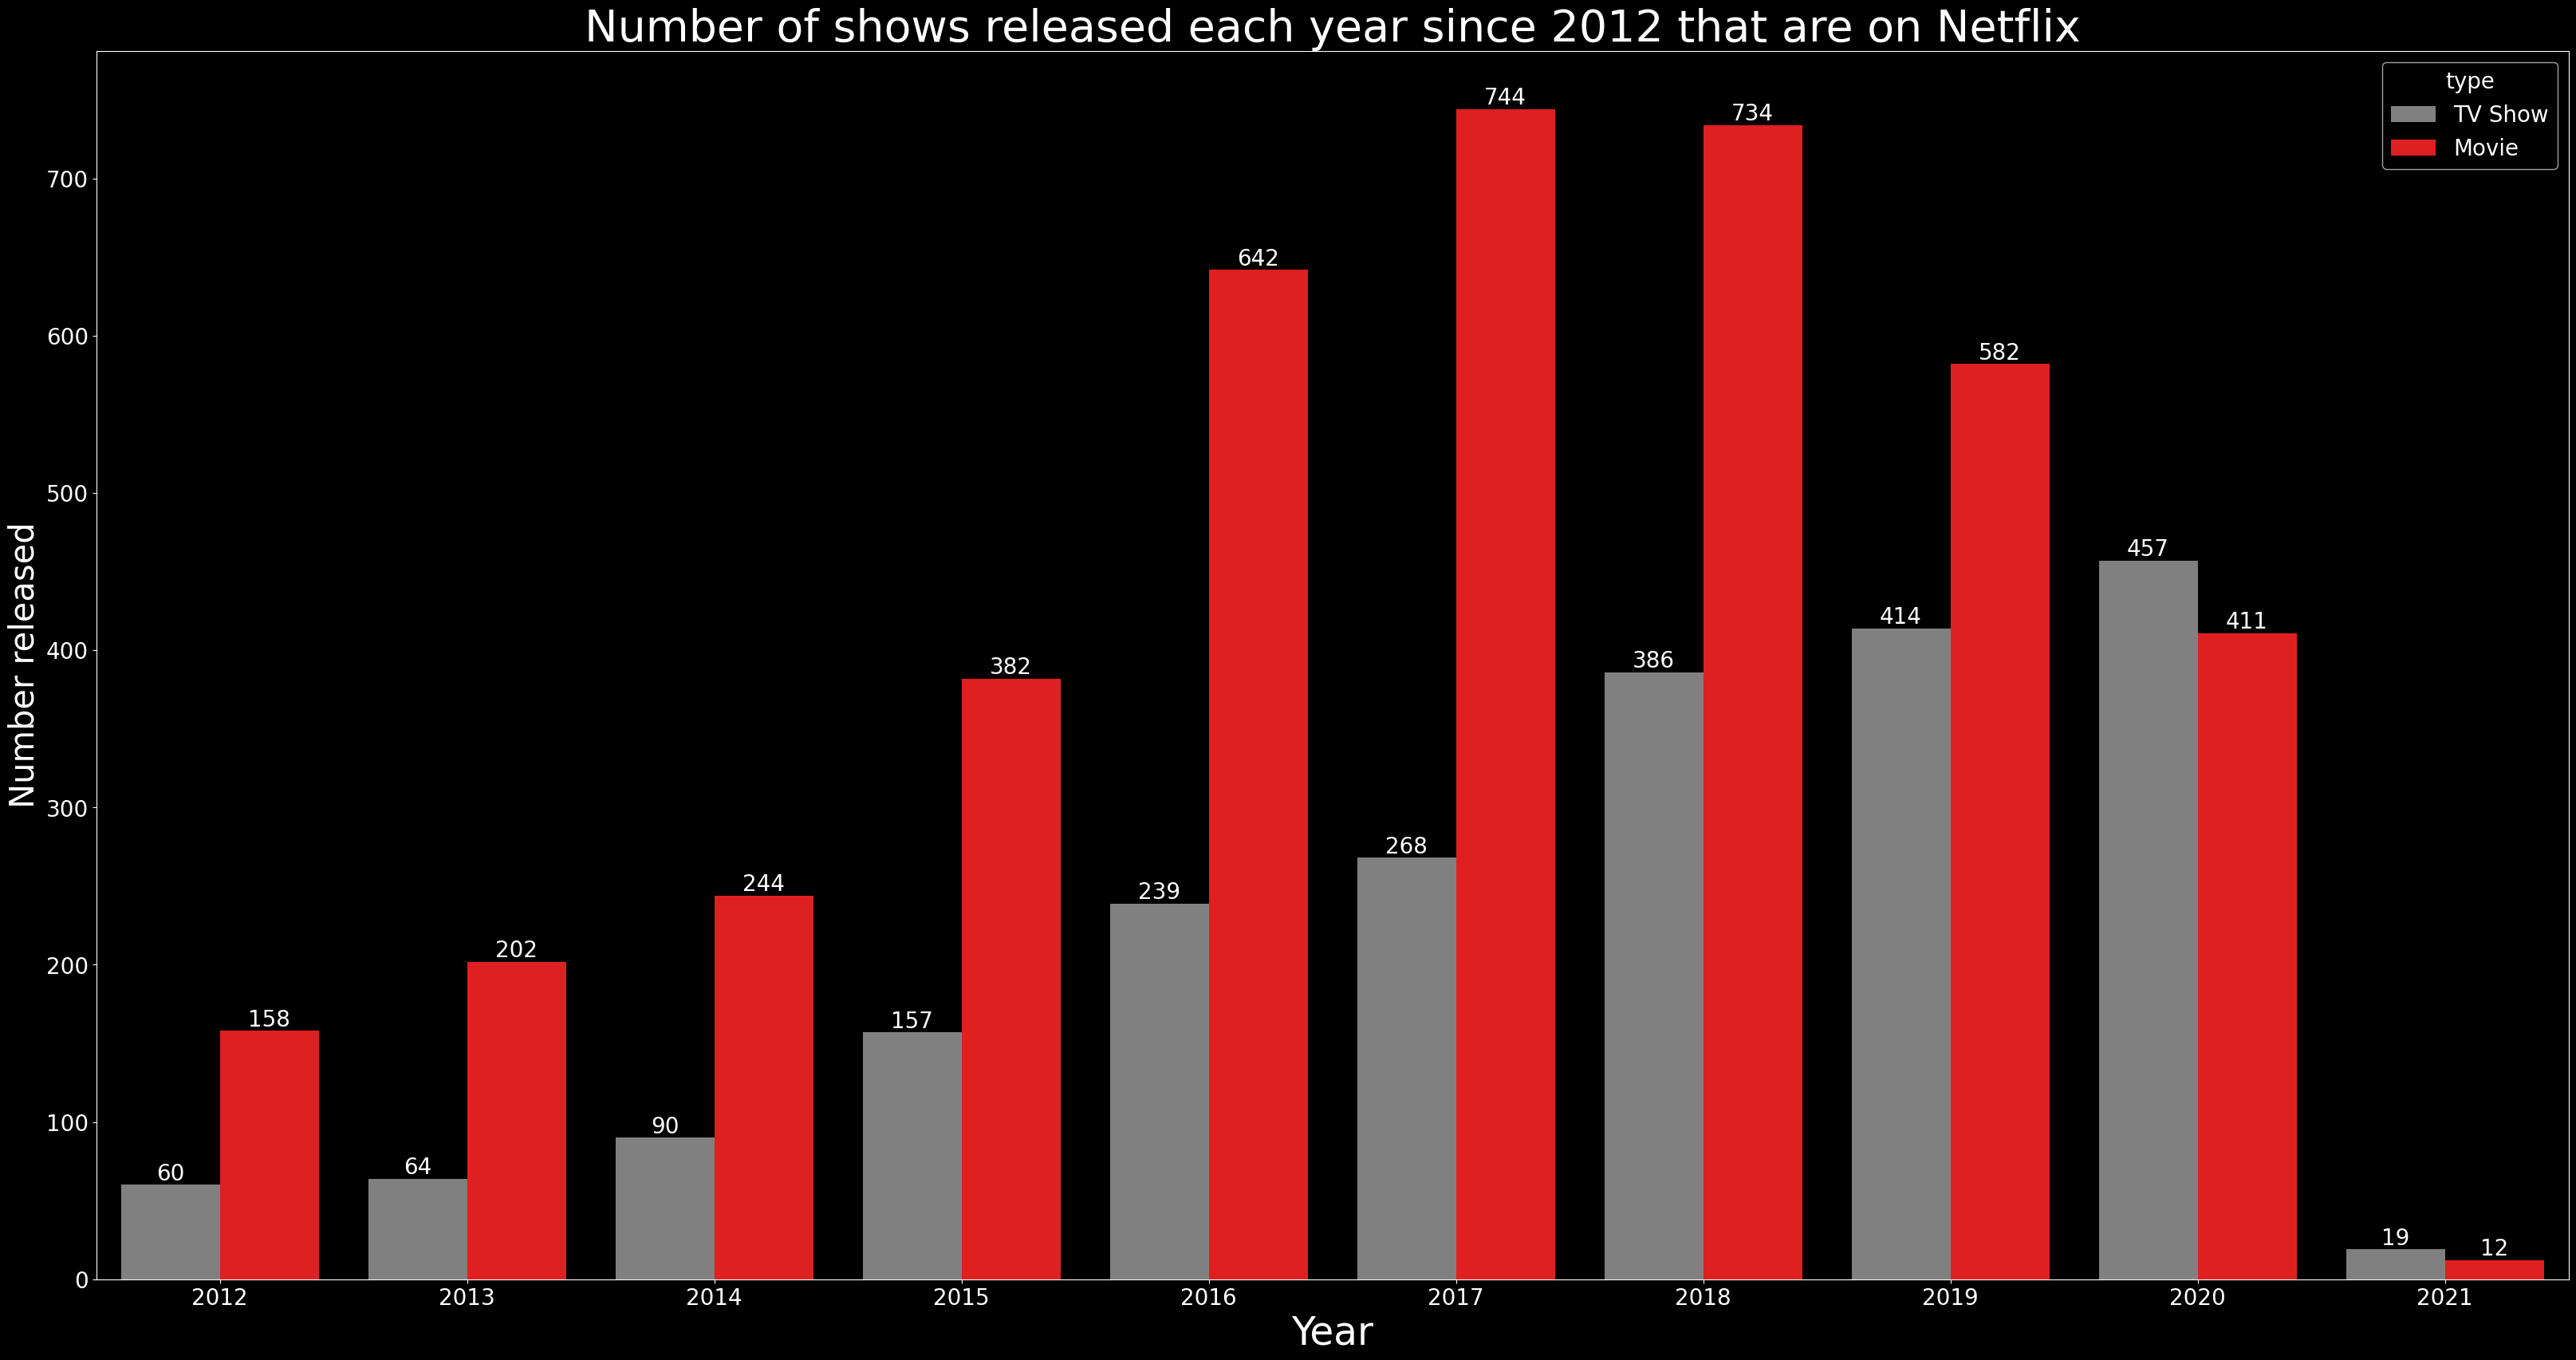

In [31]:
order = range(2012,2022)
plt.rcParams['font.size'] = 20
plt.figure(figsize=(40,20))
p = sns.countplot(x='release_year',data=Netflix, hue='type',
                  order = order,  palette=['grey', 'red'])
plt.title('Number of shows released each year since 2012 that are on Netflix').set_fontsize(40)
plt.ylabel('Number released').set_fontsize(30)
plt.xlabel('Year').set_fontsize(35)
for i in p.patches:
  p.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

- Netflix has been churning out more shows over the years with more movies than TV Shows.
- Since 2020 however, it seems to have favoured releasing more TV Shows than movies

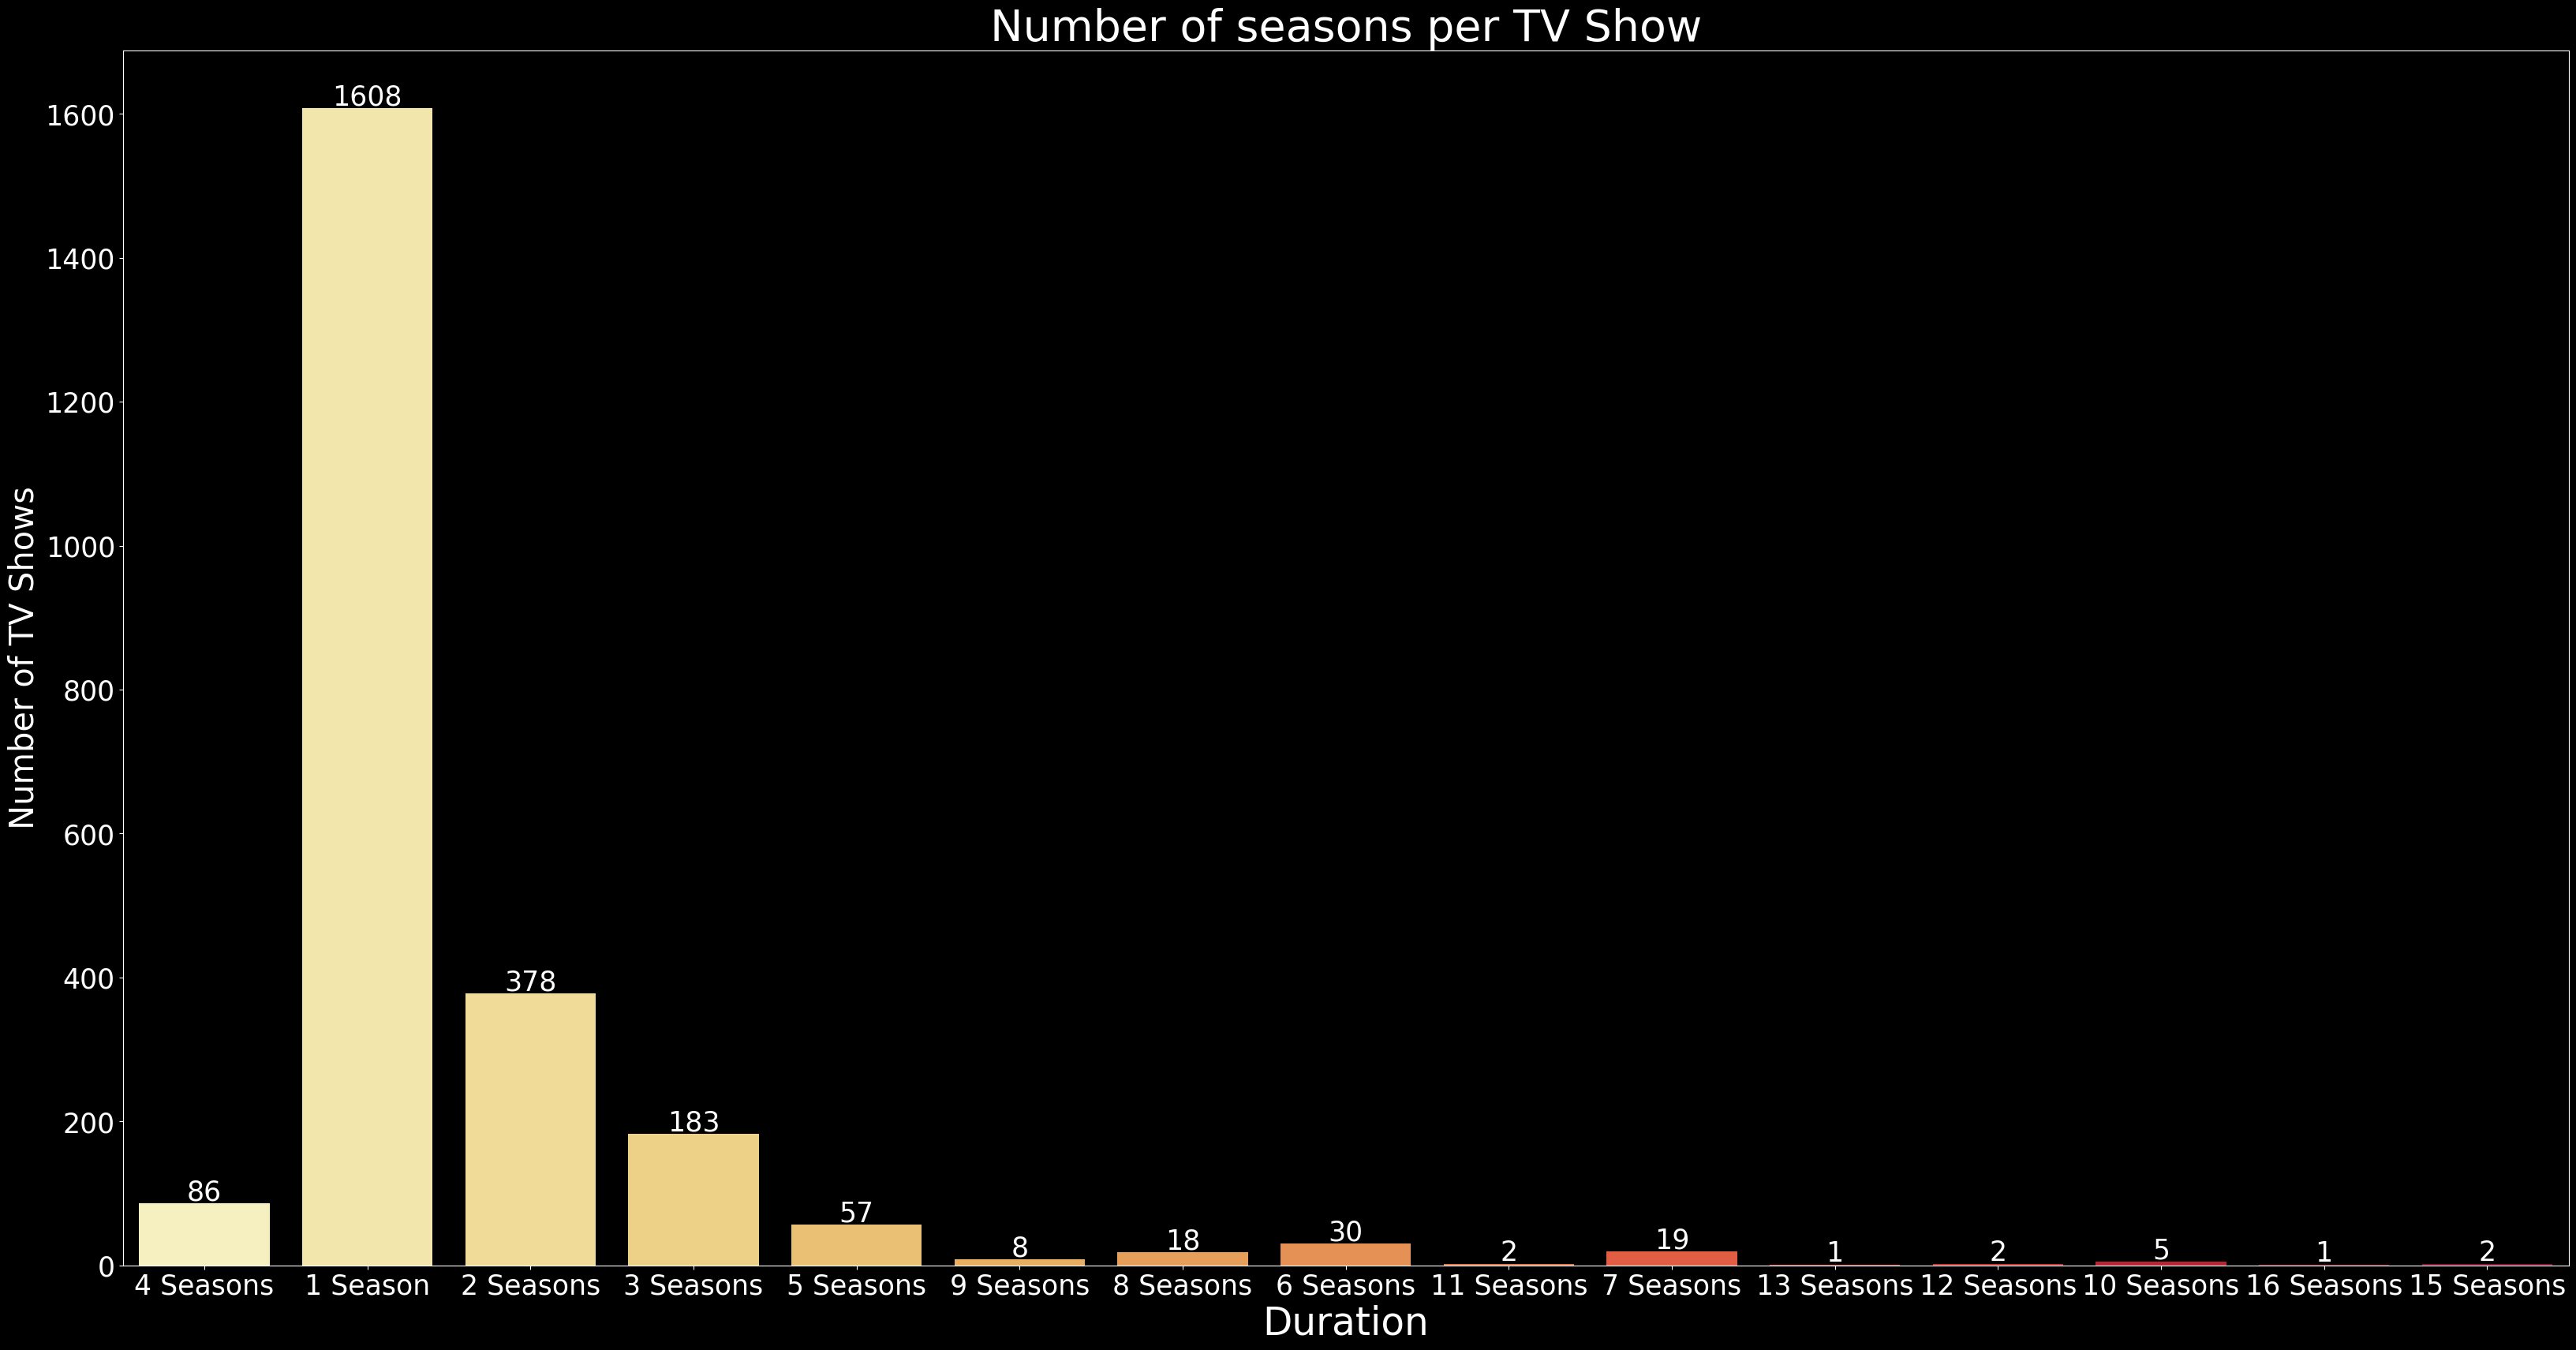

In [32]:
plt.figure(figsize=(40,20))
plt.rcParams['font.size'] = 25

p = sns.countplot(x='duration',data=Netflix[Netflix['type']=='TV Show'], palette='YlOrRd')
plt.ylabel('Number of TV Shows').set_fontsize(30)
plt.xlabel('Duration').set_fontsize(35)
plt.title('Number of seasons per TV Show').set_fontsize(40)

for i in p.patches:
  p.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [33]:
Netflix['clustering_attributes'] = (Netflix['director'] + ' ' + 
                                Netflix['cast'] +' ' + 
                                Netflix['country'] +' ' + 
                                Netflix['listed_in'] +' ' + 
                                Netflix['description'])

In [34]:
Netflix['clustering_attributes'][40]

'Muharrem Gülmez Erdem Yener, Ayhan Taş, Emin Olcay, Muharrem Gülmez, Elif Nur Kerkük, Tarık Papuççuoğlu, Suzan Aksoy, Doğa Konakoğlu, Esin Eden, Deniz Özerman Turkey Comedies, International Movies The slacker owner of a public bath house rallies his community to save it when a big developer comes to town to close it down and open a new mall.'

In [35]:
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [36]:
Netflix['clustering_attributes'] = lemmatize_verbs(Netflix['clustering_attributes'])

In [37]:
tokenizer = TweetTokenizer()

Netflix['clustering_attributes'] = Netflix['clustering_attributes'].apply(lambda x: tokenizer.tokenize(x))

In [38]:
clustering_data = Netflix['clustering_attributes']

Tokenization

In [39]:

def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False,max_features = 20000)    
X = tfidf.fit_transform(clustering_data)

In [40]:
X.shape

(7777, 20000)

In [41]:
type(X)

scipy.sparse._csr.csr_matrix

- Convert X into array form for clustering

In [42]:
X = X.toarray()

- Dimensionality reduction

In [43]:
pca = PCA(random_state=42)
pca.fit(X)

PCA(random_state=42)

Variance for different number of components

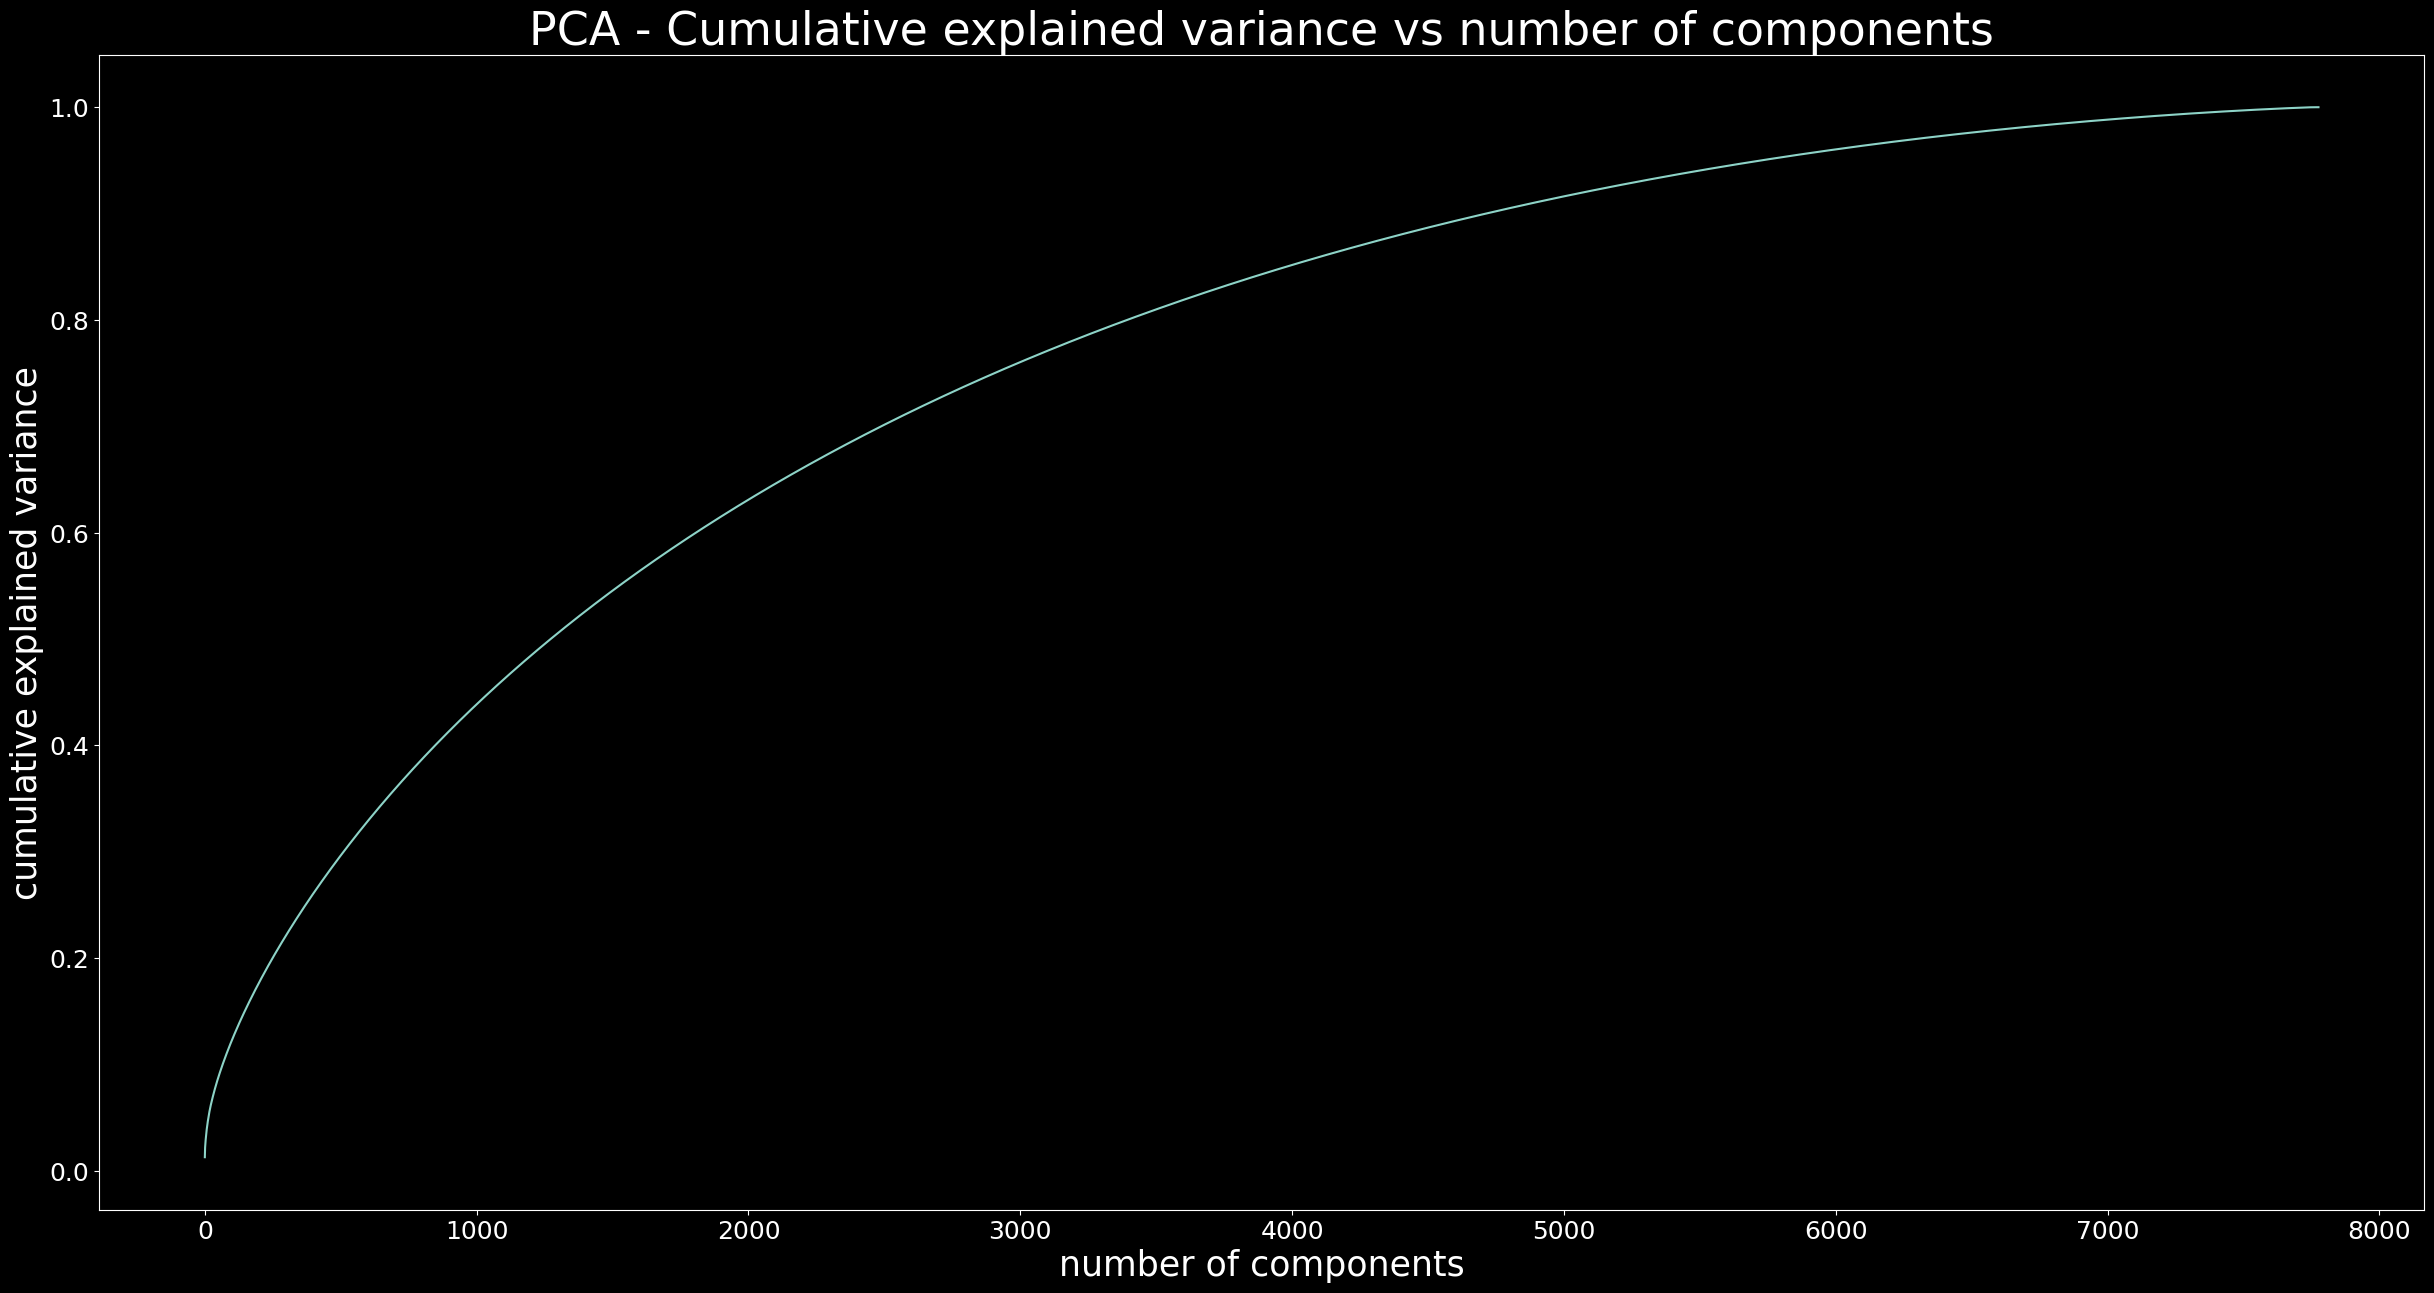

In [44]:
plt.rcParams['font.size'] = 18

plt.figure(figsize=(30,15))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA - Cumulative Explained Variance vs Number of Components').set_fontsize(33)
plt.xlabel('Number of Components').set_fontsize(25)
plt.ylabel('Cumulative Explained Variance').set_fontsize(25)

Reducing the dimensions to 4000 

In [45]:
pca = PCA(n_components=4000,random_state=42)
pca.fit(X)

PCA(n_components=4000, random_state=42)

Transformed features

In [46]:
x_pca = pca.transform(X)

Shape of transformed vectors

In [47]:
x_pca.shape

(7777, 4000)

Elbow method to find the optimal value of k

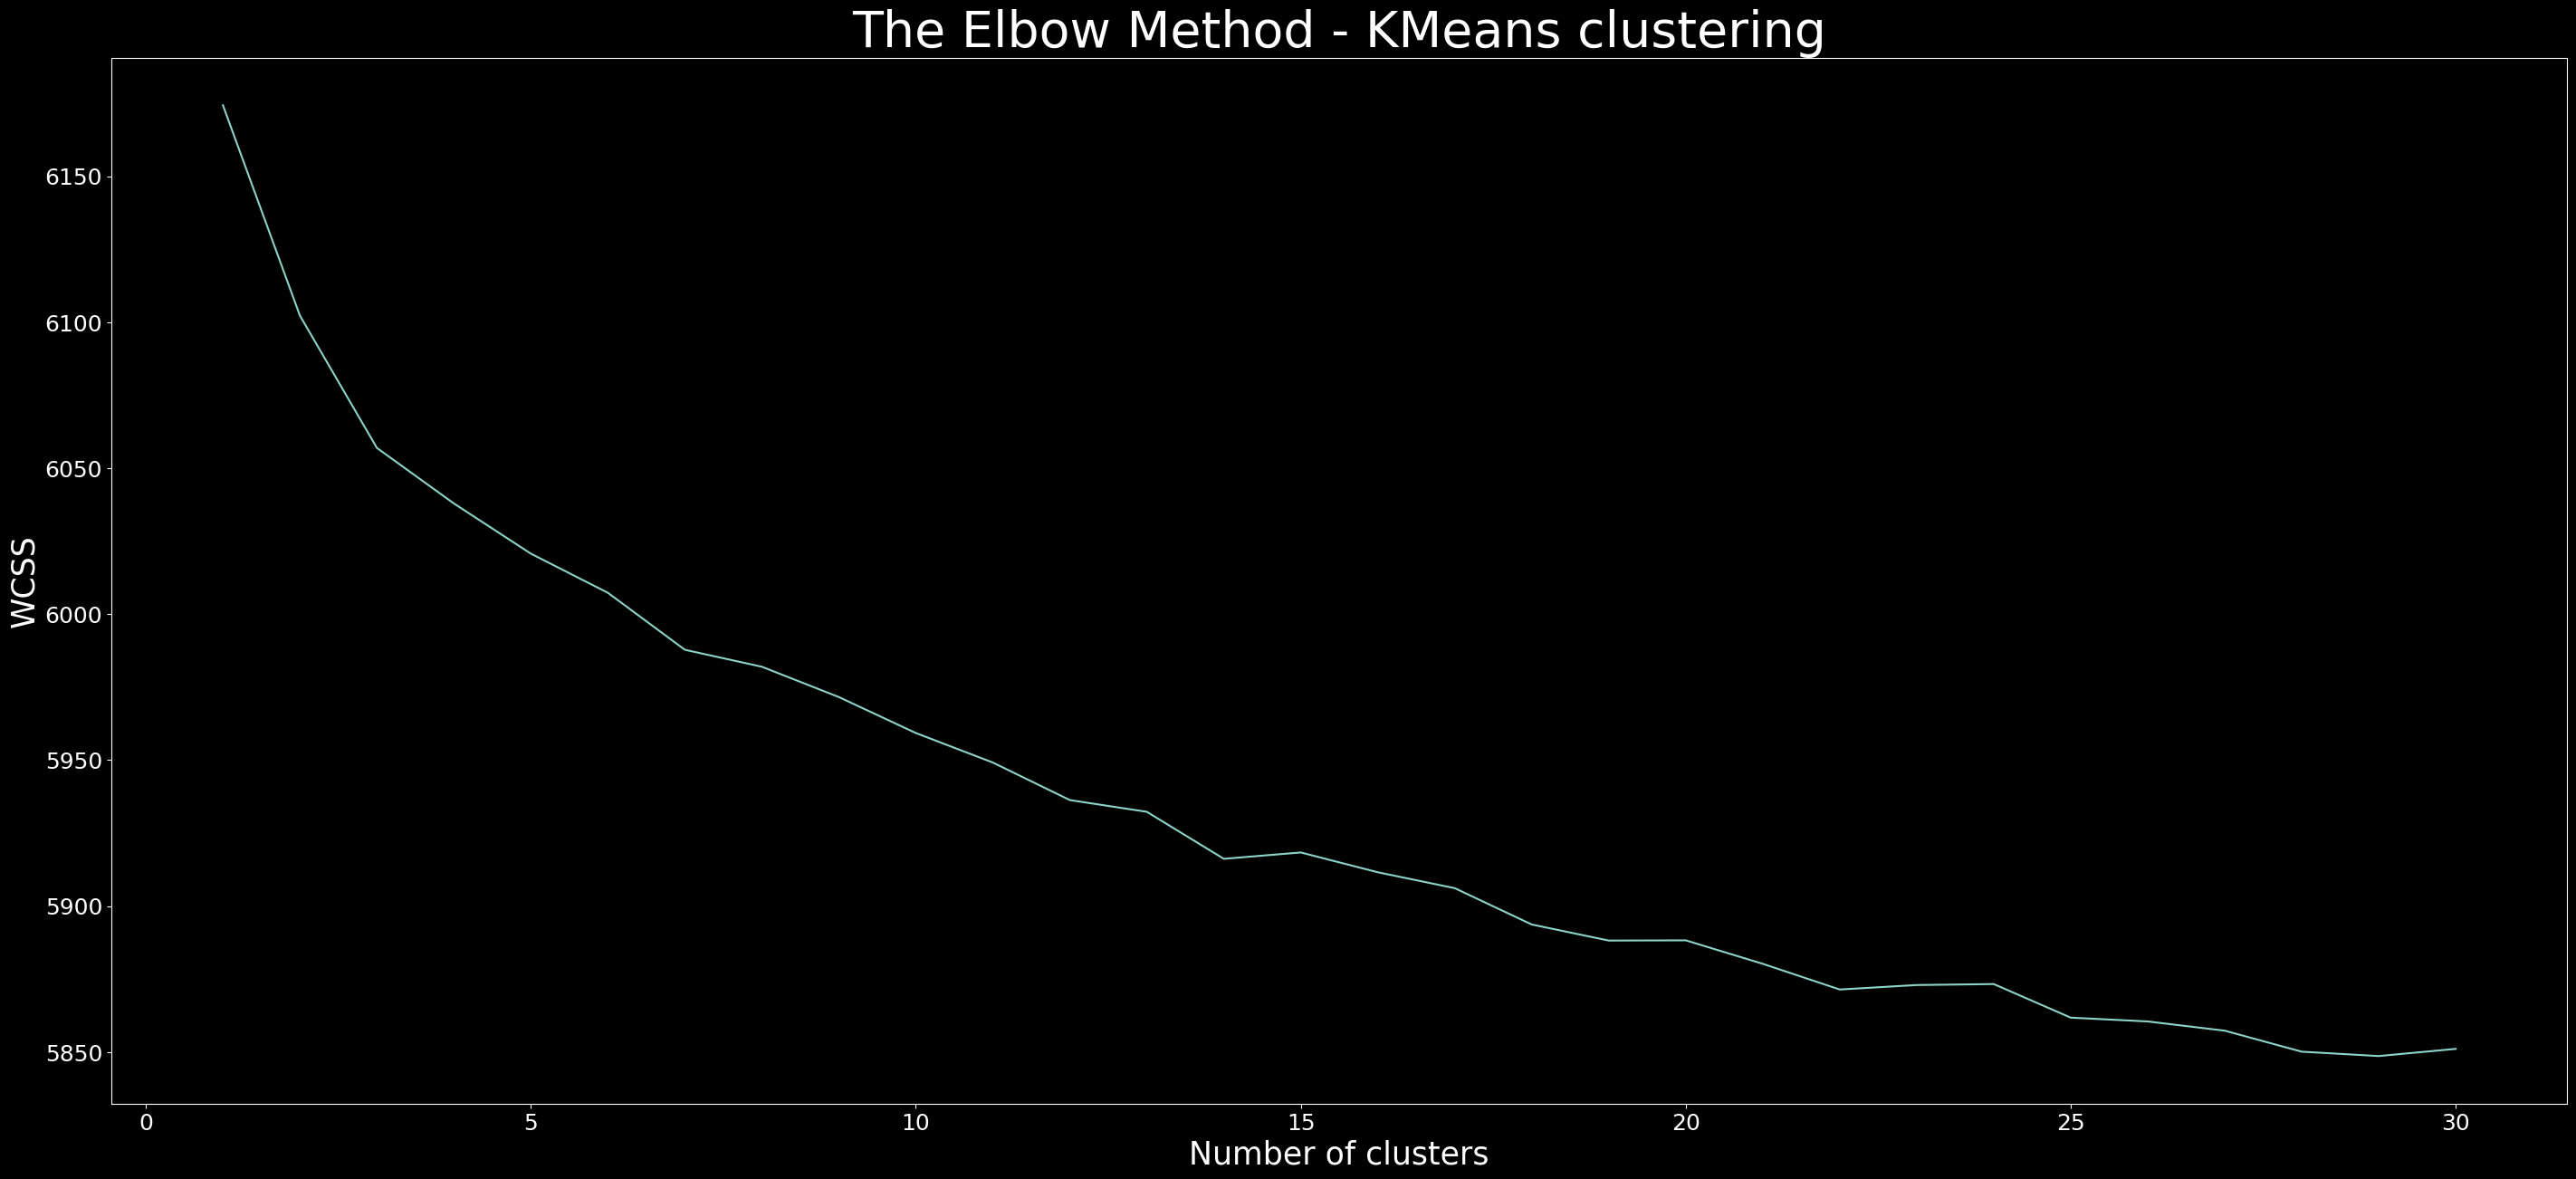

In [48]:
wcss=[]
for i in range(1,31):
  kmeans = KMeans(n_clusters=i,init='k-means++',random_state=33)
  kmeans.fit(x_pca)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1,31)
plt.figure(figsize=(35,15))
plt.plot(number_clusters,wcss)
plt.title('The Elbow Method - KMeans clustering').set_fontsize(40)
plt.xlabel('Number of clusters').set_fontsize(25)
plt.ylabel('WCSS').set_fontsize(25)

Plotting Silhouette score for different number of clusters

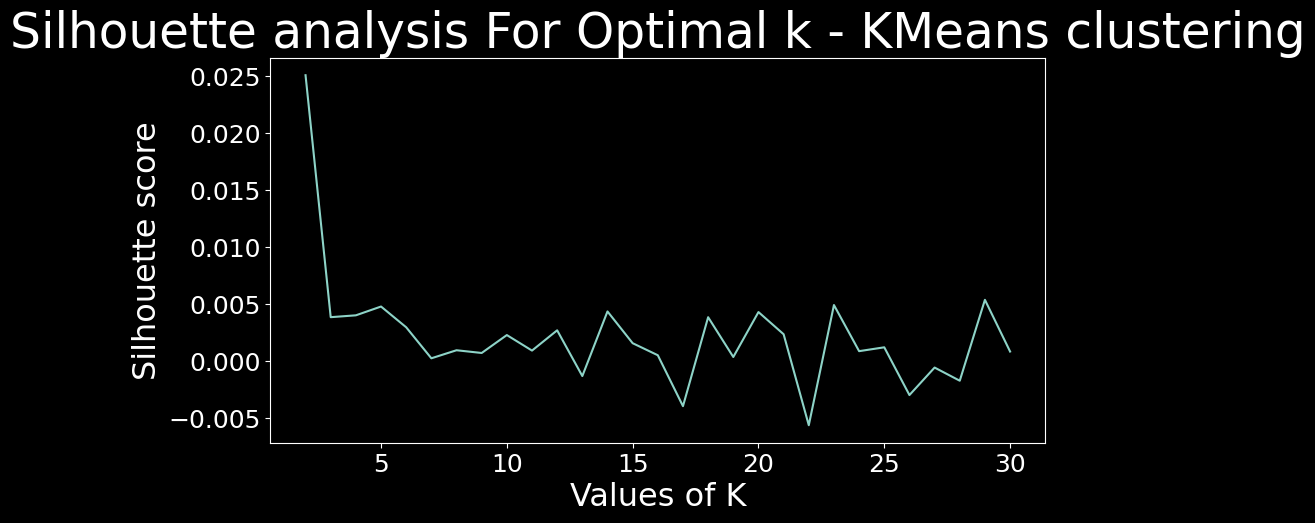

In [49]:
range_n_clusters = range(2,31)
silhouette_avg = []
for num_clusters in range_n_clusters:
  
  # initialize kmeans
  kmeans = KMeans(n_clusters=num_clusters,init='k-means++',random_state=33)
  kmeans.fit(x_pca)
  cluster_labels = kmeans.labels_
 
  # silhouette score
  silhouette_avg.append(silhouette_score(x_pca, cluster_labels))

plt.figure(figsize=(10,5))
plt.plot(range_n_clusters,silhouette_avg)
plt.xlabel('Values of K').set_fontsize(23)
plt.ylabel('Silhouette score').set_fontsize(23)
plt.title('Silhouette analysis For Optimal k - KMeans clustering').set_fontsize(35)
plt.show()

- The highest Silhouette score is obtained for 6 clusters.

- Clustering the data into 6 clusters

In [51]:
kmeans = KMeans(n_clusters=6,init='k-means++',random_state=33)
kmeans.fit(x_pca)

KMeans(n_clusters=6, random_state=33)

- Evaluation metrics - distortion, Silhouette score

In [52]:
kmeans_distortion = kmeans.inertia_
kmeans_silhouette_score = silhouette_score(x_pca, kmeans.labels_)

print((kmeans_distortion,kmeans_silhouette_score))

(6007.333262643691, 0.0029845310249981185)


- Adding a K-Means Cluster number attribute

In [53]:
Netflix['K-Means_Cluster'] = kmeans.labels_

- Number of Movies and Tv shows in each cluster

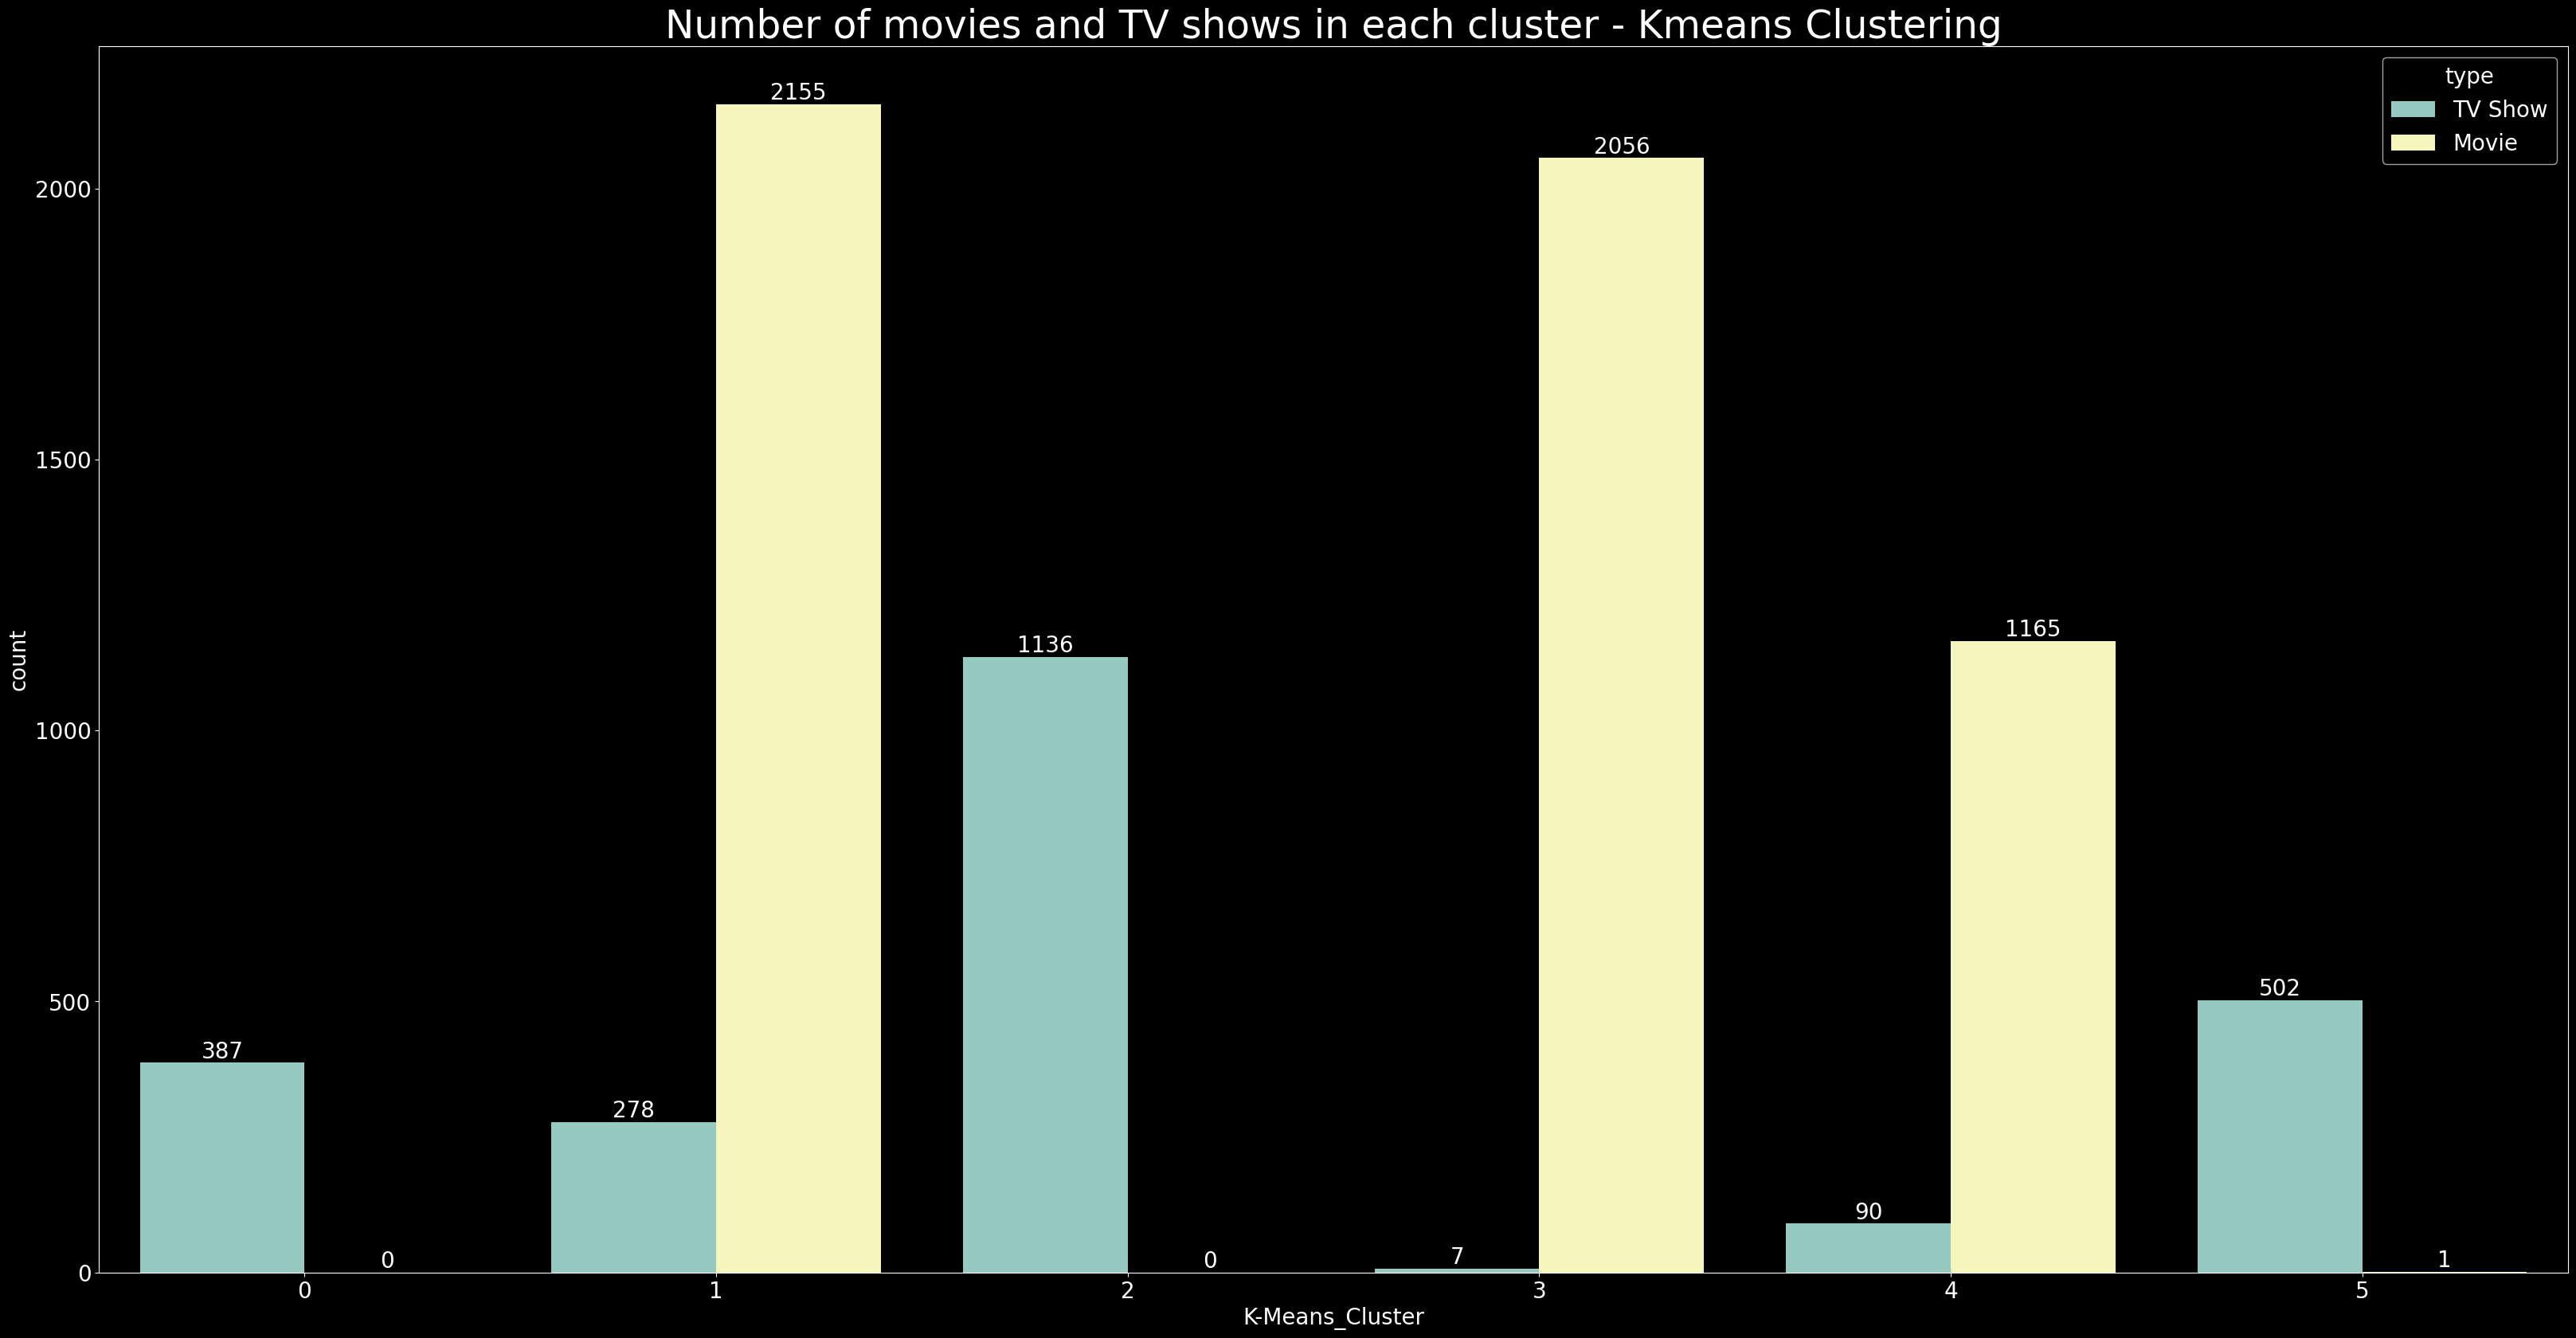

In [57]:
plt.rcParams['font.size'] = 20

plt.figure(figsize=(40,20))
q = sns.countplot(x='K-Means_Cluster',data=Netflix, hue='type')
plt.title('Number of movies and TV shows in each cluster - Kmeans Clustering').set_fontsize(35)
for i in q.patches:
  q.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

- Building a wordcloud for the movie descriptions

In [61]:
def kmeans_worldcloud(cluster_num):
  comment_words = ''
  stopwords = set(STOPWORDS)

  # iterate through the csv file
  for val in Netflix[Netflix['K-Means_Cluster']==cluster_num].description.values:
      
      # typecaste each val to string
      val = str(val)

      # split the value
      tokens = val.split()
      
      # Converts each token into lowercase
      for i in range(len(tokens)):
          tokens[i] = tokens[i].lower()
      comment_words += " ".join(tokens)+" "

  wordcloud = WordCloud(width = 700, height = 700,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(comment_words)


  # plot the WordCloud image                      
  plt.figure(figsize = (28,12), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

  plt.show()

- Wordcloud for cluster 0

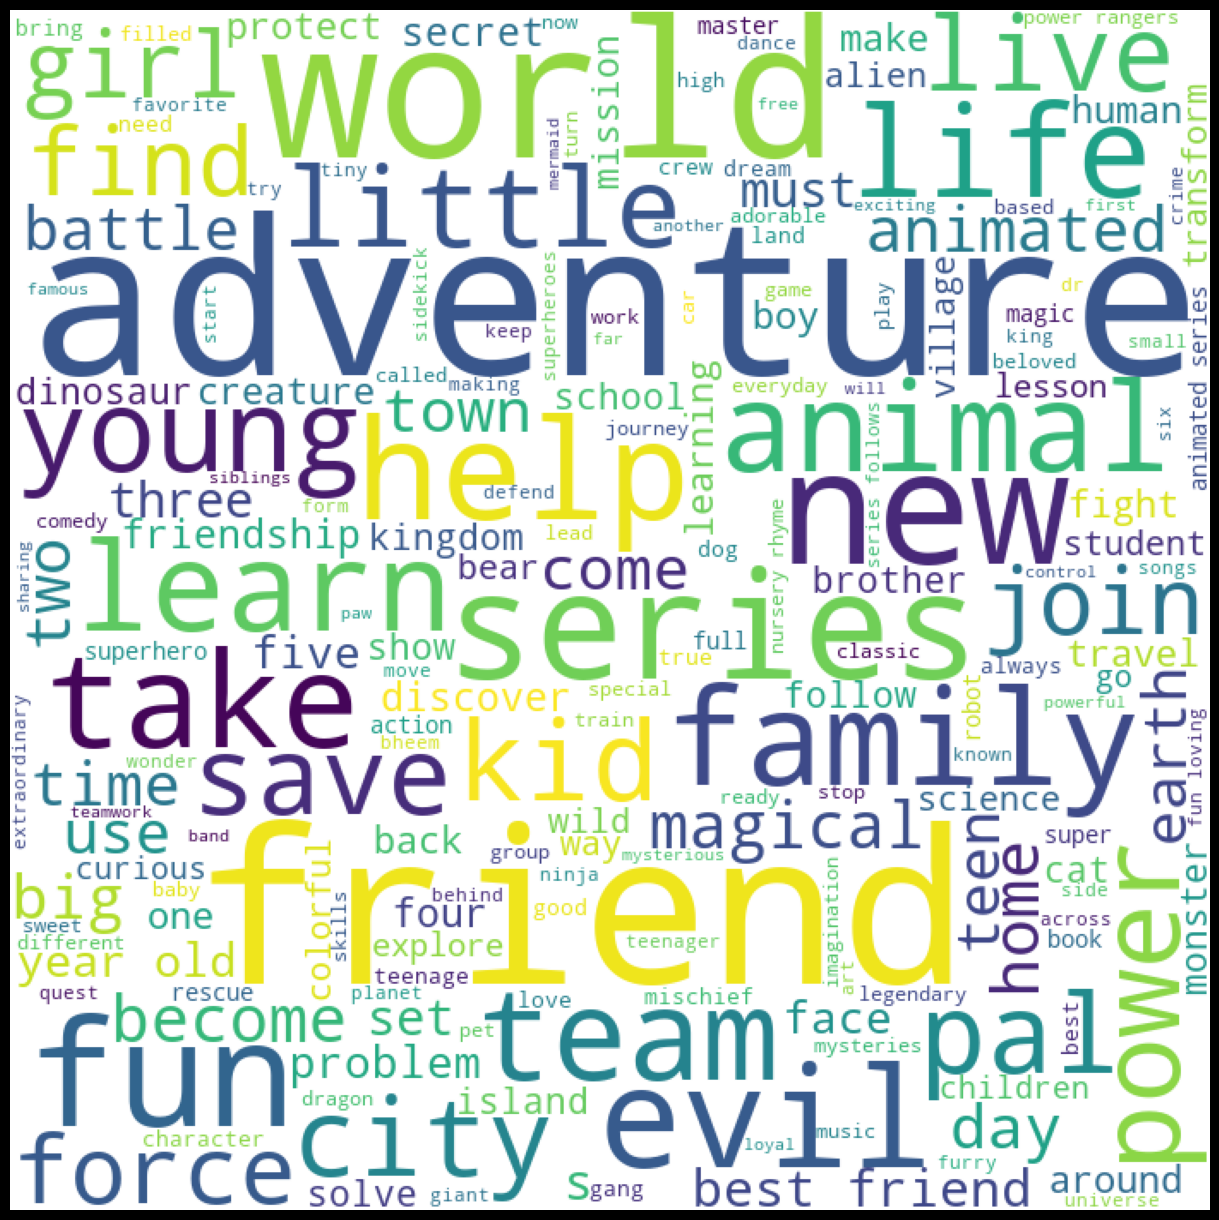

In [62]:
kmeans_worldcloud(0)

- Wordcloud for cluster 1

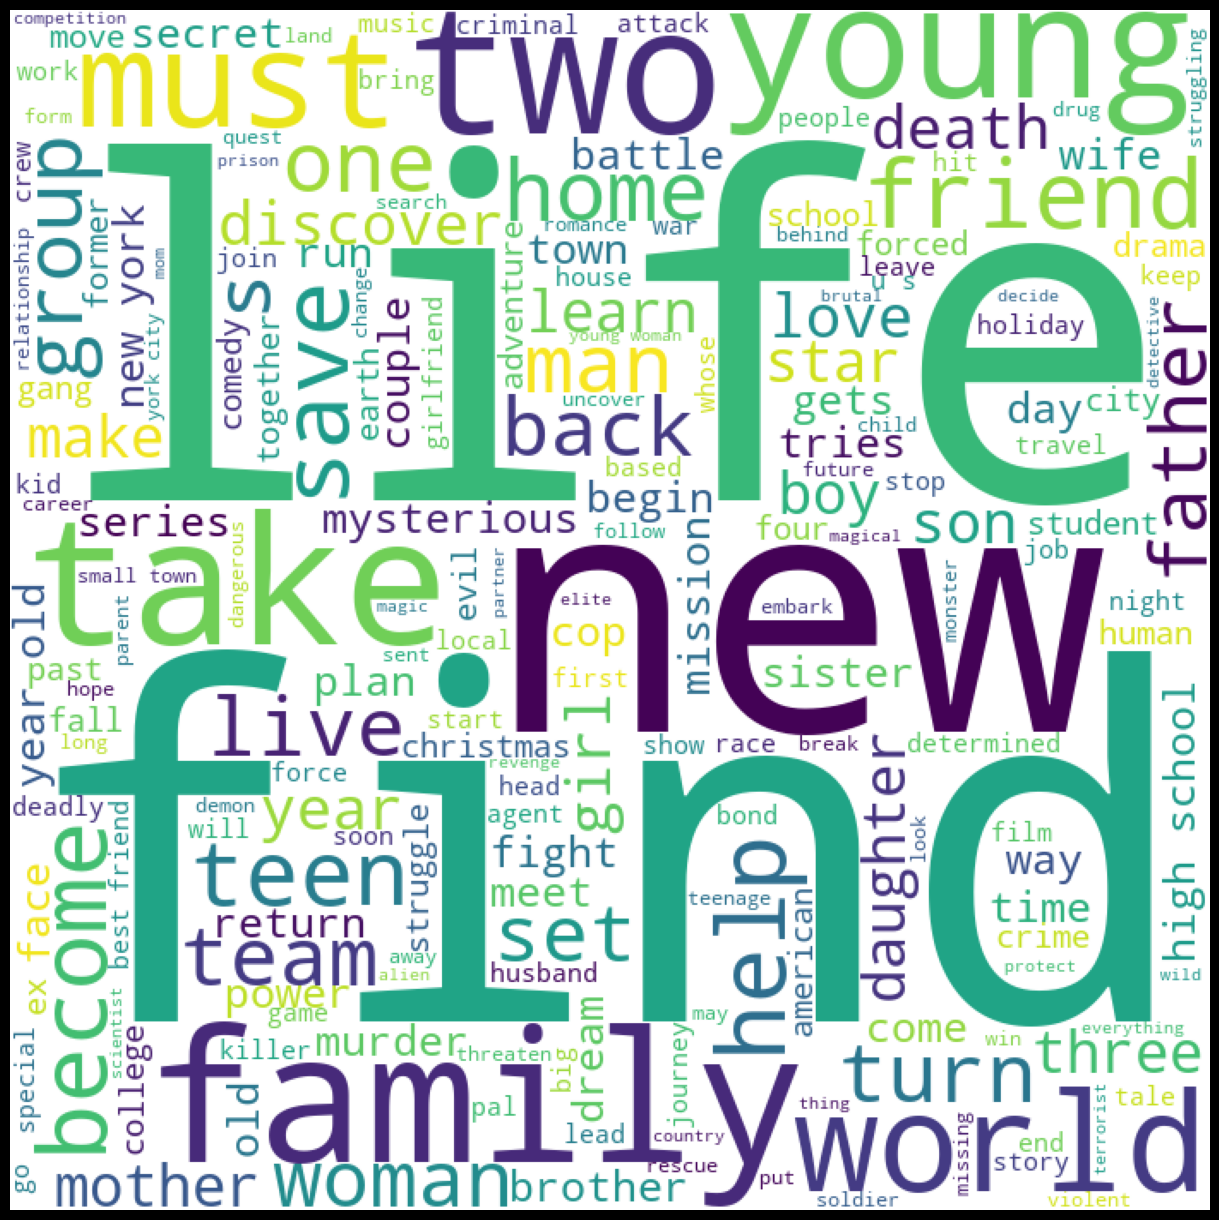

In [63]:
kmeans_worldcloud(1)

- Wordcloud for cluster 2

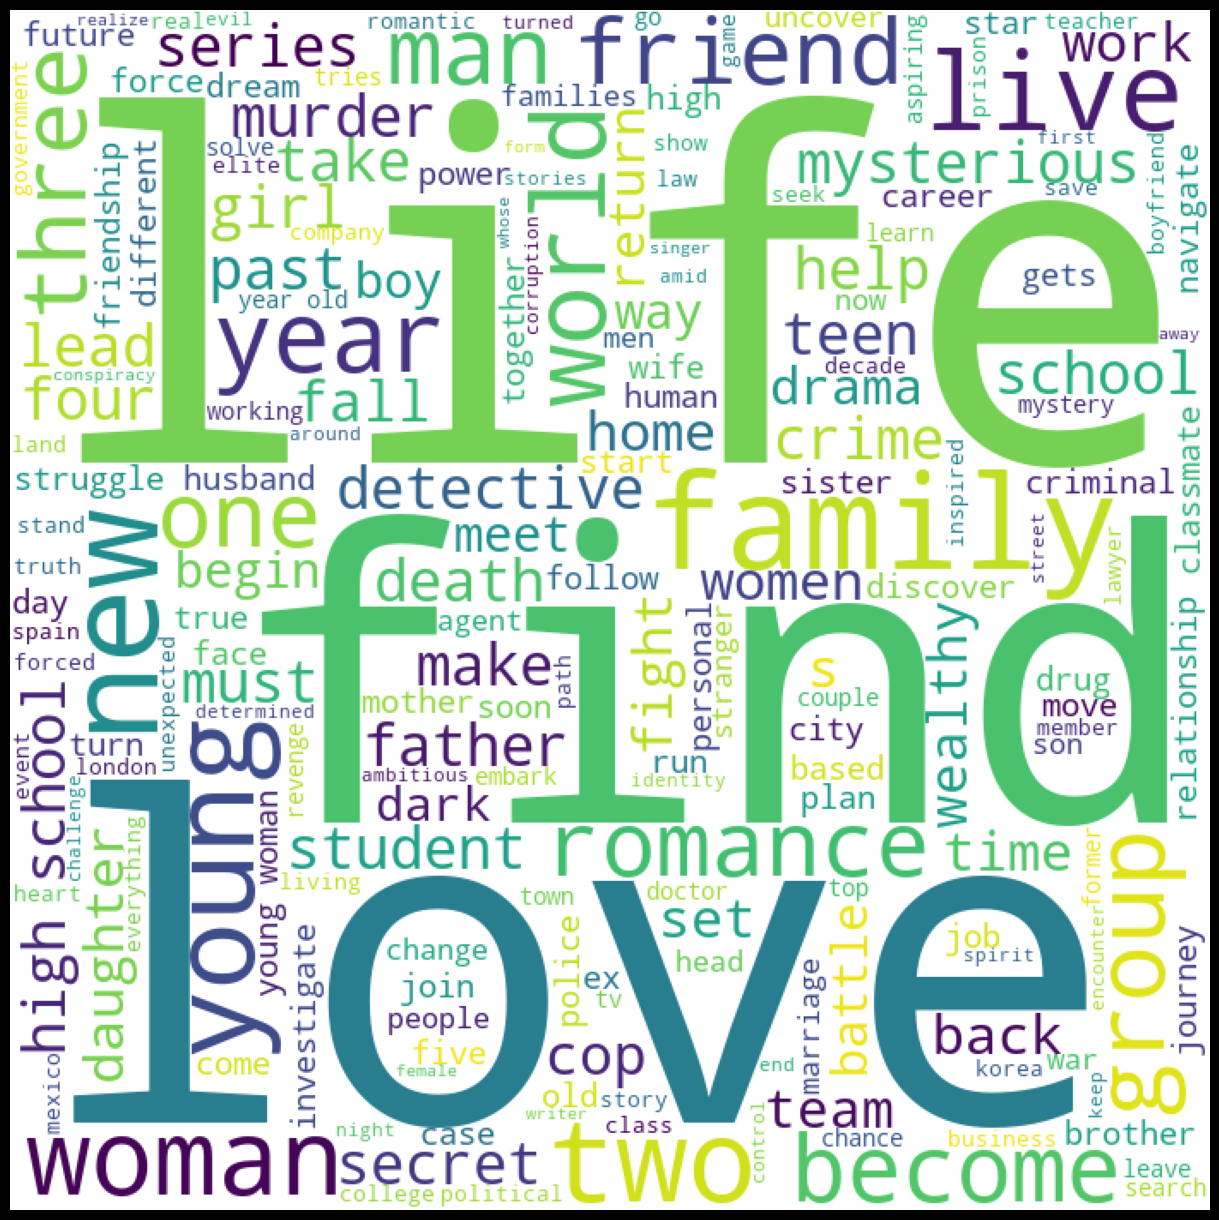

In [64]:
kmeans_worldcloud(2)

- Wordcloud for cluster 3

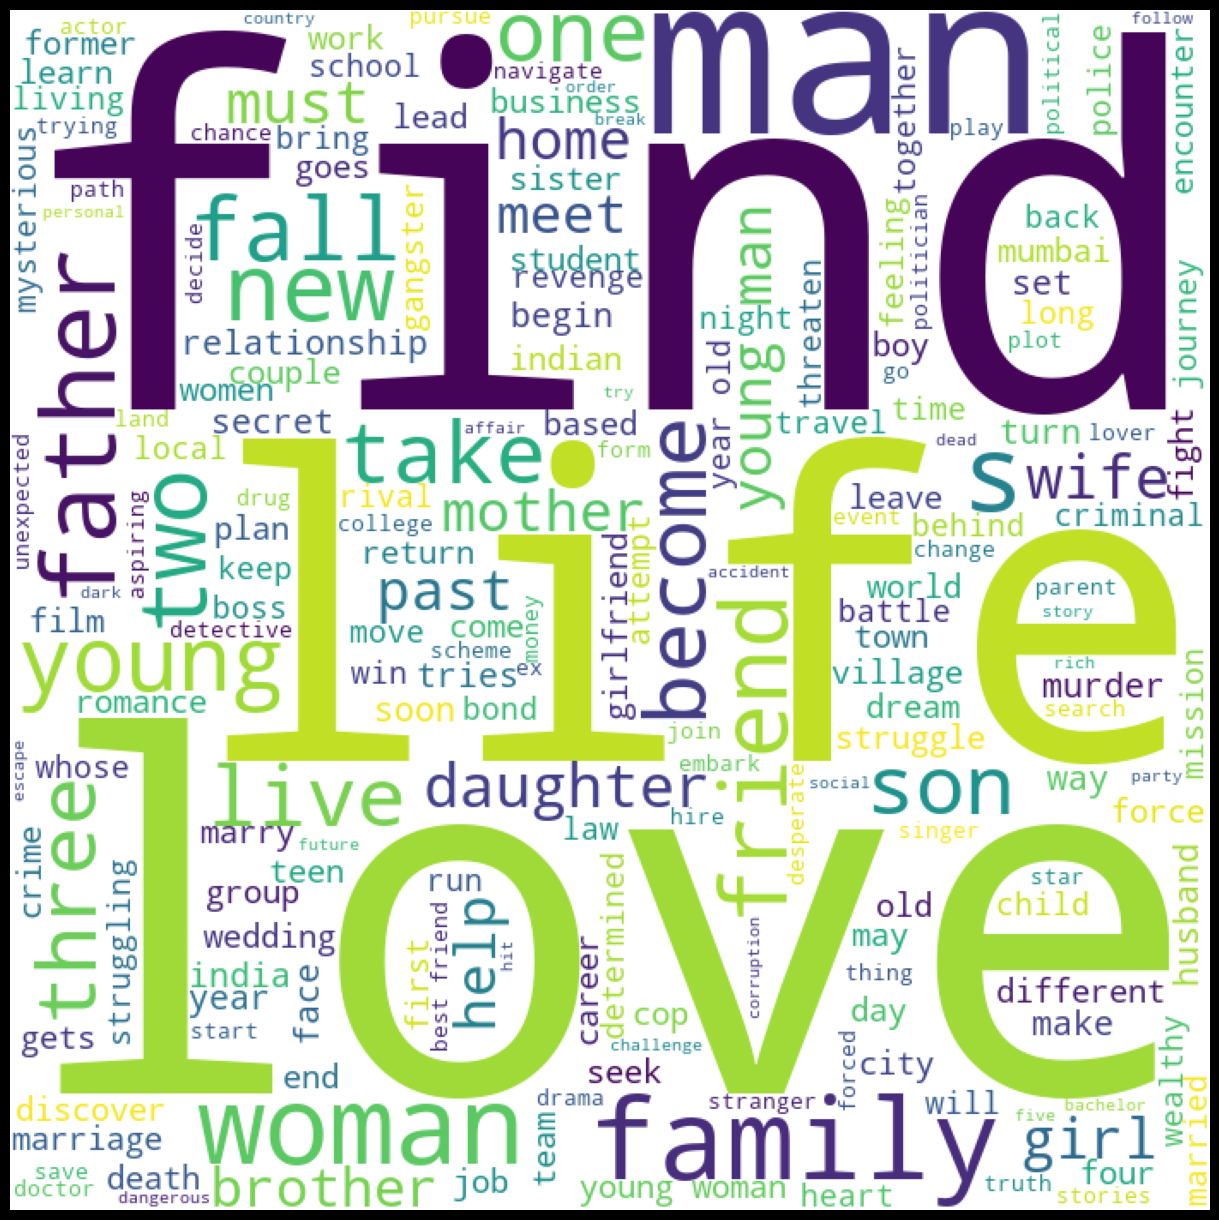

In [65]:
kmeans_worldcloud(3)

- Wordcloud for cluster 4

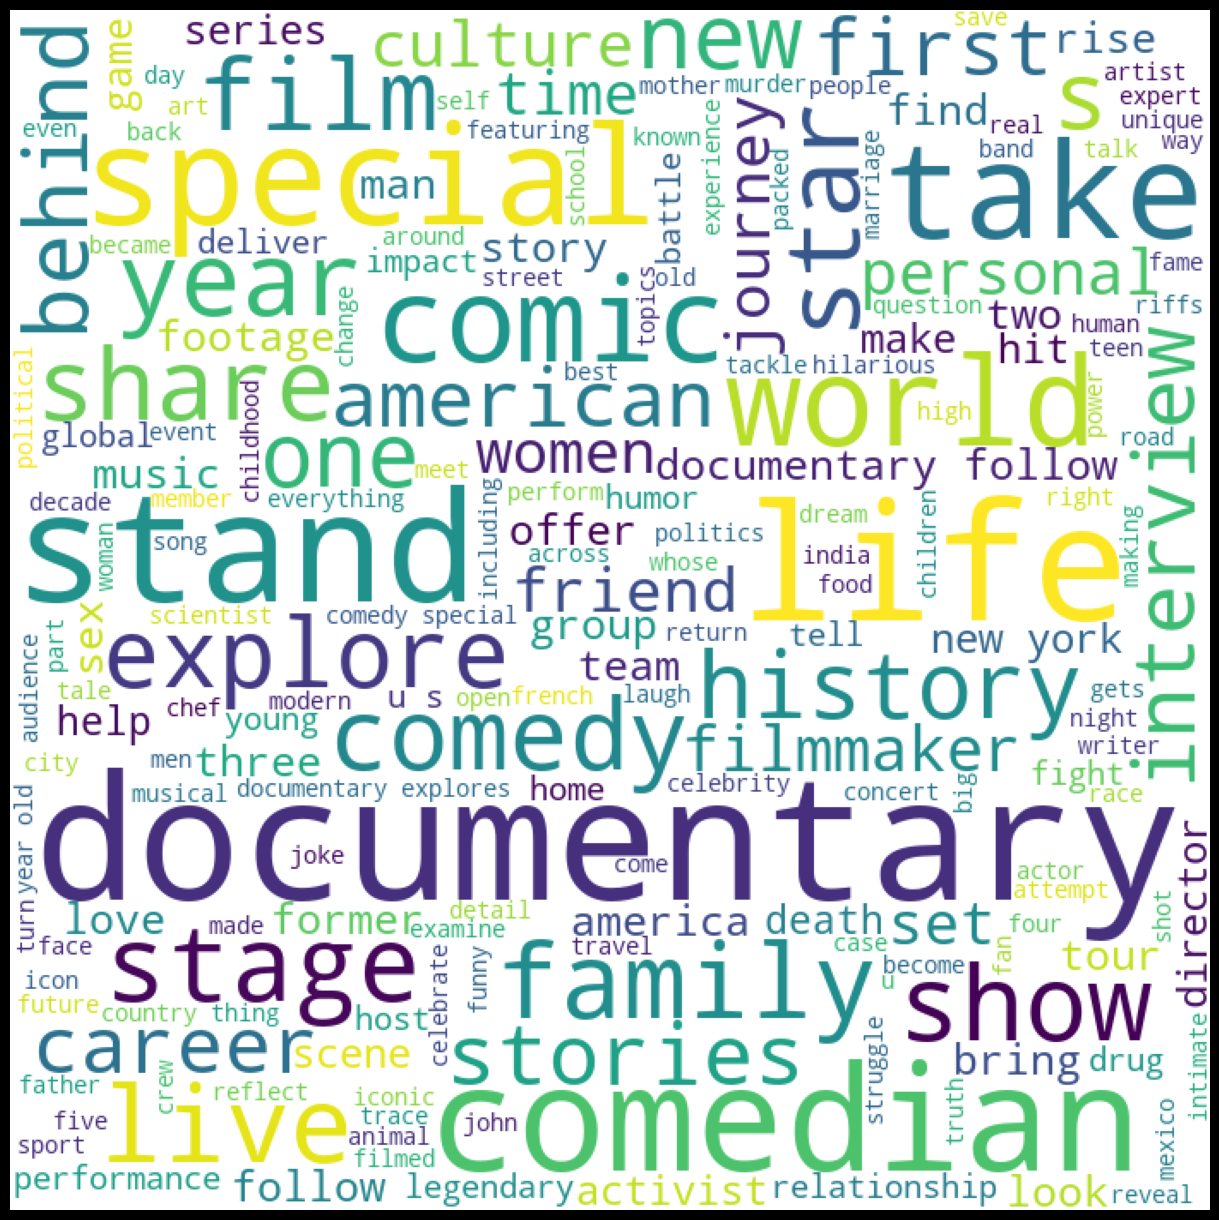

In [66]:
kmeans_worldcloud(4)

- Wordcloud for cluster 5

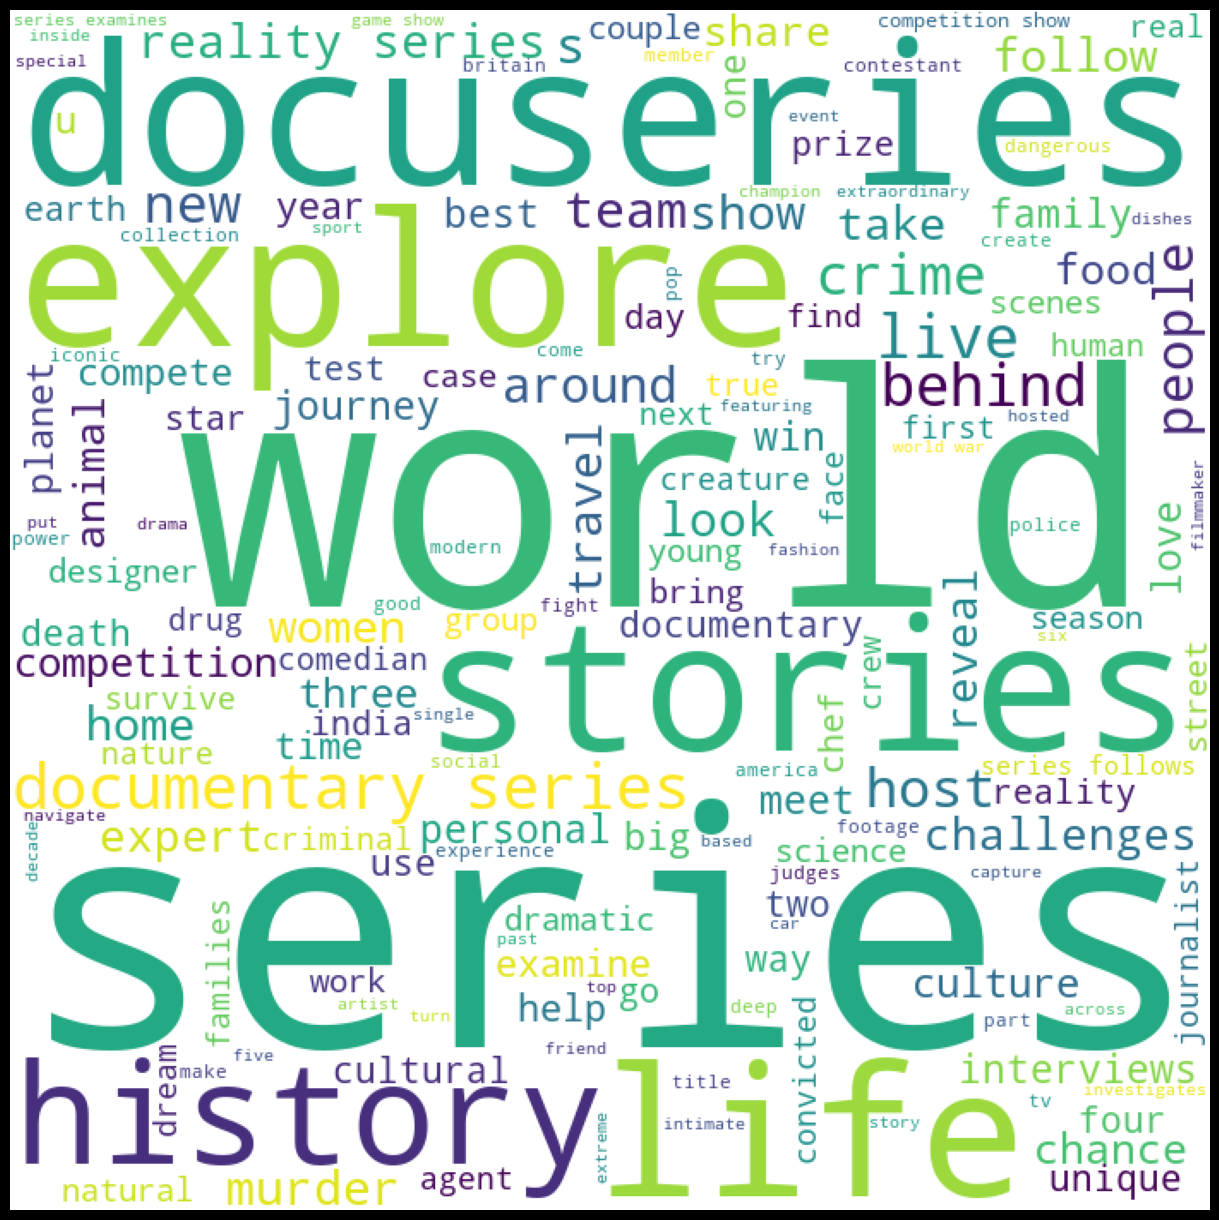

In [67]:
kmeans_worldcloud(5)